## Description

In this notebook, we use the results of lipid quantification in Notebook 4 to segment the images.   

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (600, 1000)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [9]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 84 formulas for cerebellum
Loaded 43 formulas for bladder


In [10]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

Load the quantification results:

In [11]:
masserstein_estimation = {n : [] for n in image_names}
masserstein_coordinates = {n : [] for n in image_names}
for n in image_names:
    frms = lipid_formulas[n]
    with open(n + '_masserstein_quantification.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        header_formulas = header[2:]
        formula_order = [header_formulas.index(f) for f in frms]
        for l in h:
            l = l.strip().split('\t')
            masserstein_coordinates[n].append((int(l[0]), int(l[1])))
            vec = list(map(float, l[2:]))
            vec = [vec[i] for i in formula_order]
            masserstein_estimation[n].append(vec)
masserstein_estimation = {n : np.array(masserstein_estimation[n]) for n in image_names}
masserstein_coordinates = {n : np.array(masserstein_coordinates[n]) for n in image_names}

In [12]:
single_peak_intensities = {n : [] for n in image_names}
intensity_coordinates = {n : [] for n in image_names}
for n in image_names:
    frms = lipid_formulas[n]
    with open(n + '_single_peak_intensities.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        header_formulas = header[2:]
        formula_order = [header_formulas.index(f) for f in frms]
        for l in h:
            l = l.strip().split('\t')
            intensity_coordinates[n].append((int(l[0]), int(l[1])))
            vec = list(map(float, l[2:]))
            vec = [vec[i] for i in formula_order]
            single_peak_intensities[n].append(vec)
single_peak_intensities = {n : np.array(single_peak_intensities[n]) for n in image_names}
intensity_coordinates = {n : np.array(intensity_coordinates[n]) for n in image_names}

## Segmentation

### FOR TESTING PURPOSES restrict to four lipids

In [13]:
# for n in image_names:
#     single_peak_intensities[n] = single_peak_intensities[n][:, 10:14]
#     masserstein_estimation[n] = masserstein_estimation[n][:, 10:14]

First, we'll compute K-means segmentations based on peak intensities. 

In [14]:
nclust = 4
km = KMeans(n_clusters=nclust, n_init='auto')

In [15]:
intensity_segmentation = {n : np.zeros(single_peak_intensities[n].shape, dtype='int') for n in image_names}
for n in image_names:
    intsy_matrix = single_peak_intensities[n]
    for j in range(intsy_matrix.shape[1]):
        segm = km.fit_predict(intsy_matrix[:,j:(j+1)])
        cluster_centers = km.cluster_centers_[:,0]
        cluster_order = np.argsort(np.argsort(cluster_centers))
        relabeled_segm = cluster_order[segm]
        intensity_segmentation[n][:,j] = relabeled_segm
    

Visualize an example segmentation:

<IPython.core.display.Javascript object>


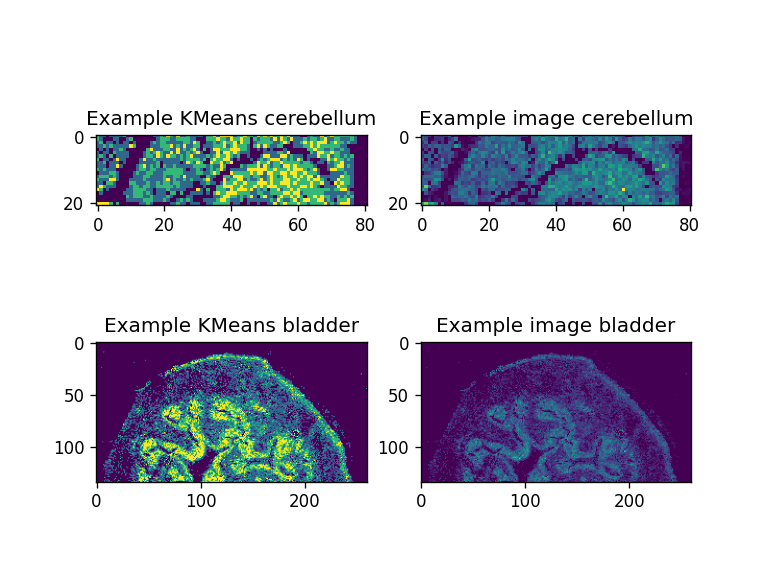

In [16]:
example_cerebellum_segm = np.zeros(image_shapes['cerebellum'])
example_cerebellum_pimg = np.zeros(image_shapes['cerebellum'])
example_bladder_segm = np.zeros(image_shapes['bladder'])
example_bladder_pimg = np.zeros(image_shapes['bladder'])
lipid_id = 2
for i, l in enumerate(intensity_coordinates['cerebellum']):
    example_cerebellum_segm[l[0], l[1]] = intensity_segmentation['cerebellum'][i, lipid_id]
    example_cerebellum_pimg[l[0], l[1]] = single_peak_intensities['cerebellum'][i, lipid_id]
for i, l in enumerate(intensity_coordinates['bladder']):
    example_bladder_segm[l[0], l[1]] =  intensity_segmentation['bladder'][i, lipid_id]
    example_bladder_pimg[l[0], l[1]] = single_peak_intensities['bladder'][i, lipid_id]
        
plt.figure()
plt.subplot(221)
plt.title('Example KMeans cerebellum')
plt.imshow(example_cerebellum_segm)
plt.subplot(222)
plt.title('Example image cerebellum')
plt.imshow(example_cerebellum_pimg)
plt.subplot(223)
plt.title('Example KMeans bladder')
plt.imshow(example_bladder_segm)
plt.subplot(224)
plt.title('Example image bladder')
plt.imshow(example_bladder_pimg)
plt.show()

Now, compute spatial-DGMM segmentations based on masserstein estimates.  
First, load R and the Cardinal package

In [17]:
%load_ext rpy2.ipython

In [18]:
%R suppressPackageStartupMessages(library('Cardinal'))

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [19]:
%R setCardinalBPPARAM(MulticoreParam())

o{'Cardinal.bpparam': class: SerialParam
  bpisup: FALSE; bpnworkers: 1; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: 2592000; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpforceGC: FALSE
  bplogdir: NA
  bpresultdir: NA
, }

Convert our intensity arrays to Pandas DataFrames

In [20]:
cerebellum_df = pd.DataFrame(masserstein_estimation['cerebellum'])
cerebellum_df.columns = ['L%i' % i for i in range(len(cerebellum_df.columns))]
cerebellum_coords = [list(x) for x in masserstein_coordinates['cerebellum']]
bladder_df = pd.DataFrame(masserstein_estimation['bladder'])
bladder_df.columns = ['L%i' % i for i in range(len(bladder_df.columns))]
bladder_coords = [list(x) for x in masserstein_coordinates['bladder']]
cerebellum_df

L0        L1        L2        L3        L4        L5        L6  \
0    -0.000000  0.006690  0.002901  0.010288  0.004844  0.000000  0.022566   
1     0.000000 -0.000000  0.003619  0.000000  0.002977  0.000000  0.006668   
2     0.000000  0.004868  0.002687  0.009448  0.002176 -0.000000  0.020191   
3     0.001112  0.005045 -0.000000  0.008311  0.004759  0.000000  0.030486   
4     0.000000  0.003762  0.002325  0.007645  0.004356  0.000000  0.020711   
...        ...       ...       ...       ...       ...       ...       ...   
1696  0.000781  0.005079  0.002306  0.007983  0.003030  0.001377  0.031546   
1697  0.000955  0.004557  0.001389  0.006236  0.002552 -0.000000  0.027613   
1698  0.000000  0.000000  0.000000  0.000000  0.000300  0.000000  0.000930   
1699 -0.000000 -0.000000  0.000124  0.000000  0.000000  0.000000  0.001908   
1700  0.000122 -0.000000 -0.000000  0.000377  0.000417  0.000000  0.003847   

                L7        L8        L9  ...       L74       L75       L76  \
0     0.000000e+00  0.000564  0.009294  ...  0.013804  0.046199  0.000000   
1     0.000000e+00 -0.000000 -0.000000  ...  0.003214  0.013177  0.000000   
2     0.000000e+00 -0.000000  0.009712  ...  0.011637  0.037410  0.000000   
3     0.000000e+00 -0.000000  0.004793  ...  0.012413  0.043759 -0.000000   
4    -0.000000e+00 -0.000000 -0.000000  ...  0.008461  0.034950  0.000000   
...            ...       ...       ...  ...       ...       ...       ...   
1696 -0.000000e+00  0.001817 -0.000000  ...  0.016755  0.043158  0.000000   
1697  1.002117e-14  0.002305  0.003637  ...  0.016536  0.039540  0.000262   
1698  0.000000e+00 -0.000000  0.000000  ...  0.000000  0.000318 -0.000000   
1699  0.000000e+00 -0.000000 -0.000000  ...  0.000710  0.001301  0.000000   
1700  0.000000e+00 -0.000000 -0.000000  ...  0.002579  0.004005  0.000000   

           L77       L78       L79       L80       L81       L82  L83  
0     0.000000  0.026509  0.028543 -0.000000  0.000000  0.033892 -0.0  
1     0.000000  0.013613  0.015812  0.000000  0.000000  0.029204 -0.0  
2     0.000000  0.024056  0.028871 -0.000000 -0.000000  0.040573 -0.0  
3    -0.000000  0.021215  0.029135 -0.000000 -0.000000  0.035021 -0.0  
4    -0.000000  0.023562  0.030508  0.000000 -0.000000  0.042634 -0.0  
...        ...       ...       ...       ...       ...       ...  ...  
1696  0.001647  0.015251  0.019133 -0.000000  0.000155  0.030356 -0.0  
1697  0.001913  0.011954  0.017016  0.001018  0.000975  0.024655 -0.0  
1698  0.000000  0.000000  0.000000  0.000000  0.000000  0.000444  0.0  
1699  0.000000  0.000000  0.000527  0.000113  0.000282  0.001296 -0.0  
1700  0.000000  0.000858  0.002426  0.000134  0.000380  0.003644 -0.0  

[1701 rows x 84 columns]

Import the data into R

In [21]:
%R -i cerebellum_df 
%R -i cerebellum_coords
%R -i bladder_df
%R -i bladder_coords

Visualize an example signal distribution throughout the cerebellum. There is a noticeable peak at zero intensity (absent ion), causing a collapse of probability and breaking the GMM algorithm. This means that, for each lipid separately, we need to manually remove pixels with zero intensity from the image.    

In [22]:
%%R 
x <- cerebellum_df[['L1']]

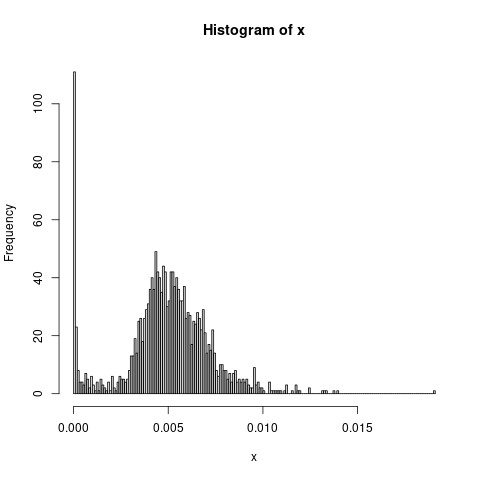

In [23]:
%%R 
hist(x, breaks=200)

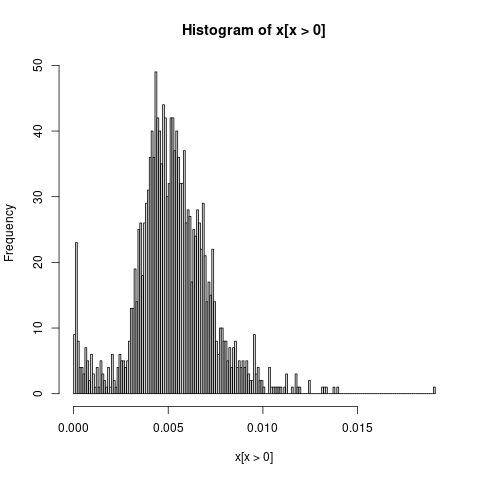

In [24]:
%%R 
hist(x[x>0], breaks=200)

Example segmentation of a selected lipid:

In [25]:
%%R 

selected_lipid = 'L16'
intsy_vec = cerebellum_df[[selected_lipid]]

Construct the image from all pixels (including zero intensity)

In [26]:
%%R 

cerebellum_fdata <- MassDataFrame(mz=1, row.names='1')
cerebellum_run <- factor(rep("run0", length(intsy_vec[[1]])))
cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=t(cerebellum_coords[c(2,1), ]))
cerebellum_image <- MSImagingExperiment(imageData=t(intsy_vec),
                                        featureData=cerebellum_fdata,
                                        pixelData=cerebellum_pdata)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In plot.window(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 2: 
R[write to console]: In plot.xy(xy, type, ...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 5: 
R[write to console]: In box(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 6: 
R[write to console]: In title(...) :
R[write to console]:  "useS4" is not a graphical parameter



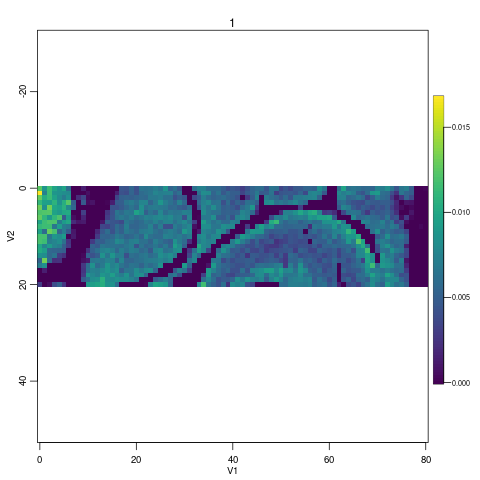

In [27]:
%%R 
image(cerebellum_image,feature=1)

Construct a filtered image - without zero intensity pixels

In [28]:
%%R 

nonzero = intsy_vec > 1e-12
nonzero_vec = log(intsy_vec[nonzero])
nonzero_coords = cerebellum_coords[, nonzero]

In [29]:
%%R 

cerebellum_fdata <- MassDataFrame(mz=1, row.names='1')
cerebellum_run <- factor(rep("run0", sum(nonzero)))
cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=t(nonzero_coords[c(2,1), ]))
cerebellum_image <- MSImagingExperiment(imageData=t(nonzero_vec),
                                        featureData=cerebellum_fdata,
                                        pixelData=cerebellum_pdata)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In plot.window(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 2: 
R[write to console]: In plot.xy(xy, type, ...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 5: 
R[write to console]: In box(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 6: 
R[write to console]: In title(...) :
R[write to console]:  "useS4" is not a graphical parameter



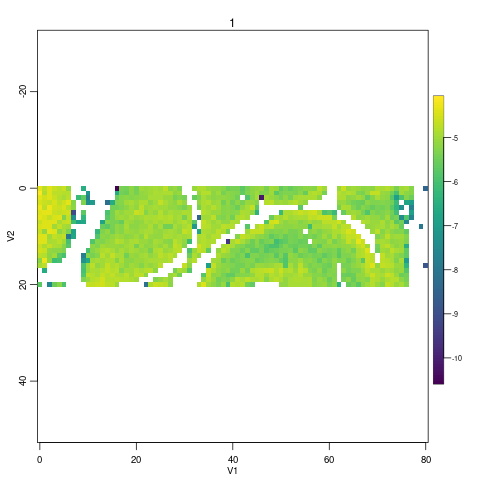

In [30]:
%%R 
image(cerebellum_image,feature=1)

Example spatial-DGMM segmentation

In [31]:
%%R 

cerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=c(1, 3, 6, 12, 24), k=3, method="adaptive",
                                init = 'gmm', tol=1e-12, iter.max=2000)

calculating spatial weights...
segmenting feature images...
r = 1, k = 3, feature = 1 . 

r = 3, k = 3, feature = 1 . 

r = 6, k = 3, feature = 1 . 

r = 12, k = 3, feature = 1 . 

r = 24, k = 3, feature = 1 . 



R[write to console]: In addition: 
R[write to console]: There were 30 warnings (use warnings() to see them)
R[write to console]: 



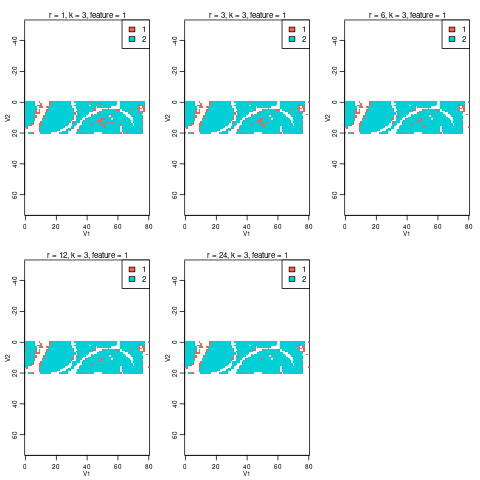

In [32]:
%%R 

image(cerebellum_sdgmm, values='class')

Segment all the lipids in the cerebellum image.  
For each lipid, the pixels with zero estimated intensity are assigned to the background segment before the segmentation.  

In [33]:
%%R

cerebellum_segments = data.frame(matrix(0, nrow=nrow(cerebellum_df), ncol=ncol(cerebellum_df)))
colnames(cerebellum_segments) = colnames(cerebellum_df)
for(column_id in 1:ncol(cerebellum_df)){
    intsy_vec = cerebellum_df[[column_id]]
    nonzero = intsy_vec > 1e-12
    nonzero_intsy_vec = intsy_vec[nonzero]
    nonzero_coords = cerebellum_coords[, nonzero]  # substitute dataset

    fdata <- MassDataFrame(mz=1, row.names='1')
    run <- factor(rep("run0", sum(nonzero)))
    pdata <- PositionDataFrame(run=run, coord=t(nonzero_coords[c(2,1), ]))
    
    image <- MSImagingExperiment(imageData=t(nonzero_intsy_vec),
                                 featureData=fdata,
                                 pixelData=pdata)
    
    sdgmm <- spatialDGMM(image, r=9, k=3, # method="adaptive", tol=1e-12, 
                         init = 'gmm', iter.max=2000)
    
    segments <- as.numeric(resultData(sdgmm)[[1]]$class)
    
    cerebellum_segments[nonzero, column_id] <- segments
}

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculatin

Segment all the lipids in the bladder image.

In [34]:
%%R

bladder_segments = data.frame(matrix(0, nrow=nrow(bladder_df), ncol=ncol(bladder_df)))
colnames(bladder_segments) = colnames(bladder_df)
for(column_id in 1:ncol(bladder_df)){
    intsy_vec = bladder_df[[column_id]]
    nonzero = intsy_vec > 1e-12
    nonzero_intsy_vec = intsy_vec[nonzero]
    nonzero_coords = bladder_coords[, nonzero]  

    fdata <- MassDataFrame(mz=1, row.names='1')
    run <- factor(rep("run0", sum(nonzero)))
    pdata <- PositionDataFrame(run=run, coord=t(nonzero_coords[c(2,1), ]))
    
    image <- MSImagingExperiment(imageData=t(nonzero_intsy_vec),
                                 featureData=fdata,
                                 pixelData=pdata)
    
    sdgmm <- spatialDGMM(image, r=15, k=3,# tol=1e-12,
                         init = 'gmm', iter.max=2000)
    
    segments <- as.numeric(resultData(sdgmm)[[1]]$class)
    
    bladder_segments[nonzero, column_id] <- segments
}

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In plot.window(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 2: 
R[write to console]: In plot.xy(xy, type, ...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 5: 
R[write to console]: In box(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 6: 
R[write to console]: In title(...) :
R[write to console]:  "useS4" is not a graphical parameter



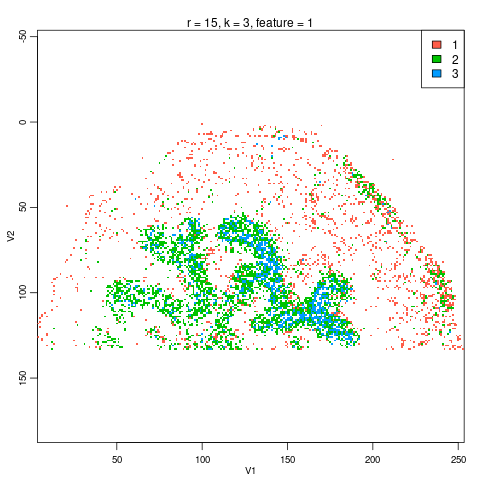

In [35]:
%%R 

image(sdgmm, values='class')

Alternative version of clustering all lipids, without filtering the zero-intensity signals (breaks down for many features because of the zero-inflated distribution):   

In [36]:
# %%R 

# # Construct an image with all lipids  
# cerebellum_fdata <- MassDataFrame(mz=1:ncol(cerebellum_df), row.names=as.character(1:ncol(cerebellum_df)))
# cerebellum_run <- factor(rep("run0", nrow(cerebellum_df)))
# cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=t(cerebellum_coords[c(2,1), ]))
# cerebellum_image <- MSImagingExperiment(imageData=t(cerebellum_df),
#                                         featureData=cerebellum_fdata,
#                                         pixelData=cerebellum_pdata)
# # Univariate segmentation of all features
# cerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=6, k=3, method="adaptive", dist='chebyshev',
#                                 init = 'gmm', tol=1e-12, iter.max=2000)

# # Convert Cardinal objects to segmentation arrays
# cerebellum_segments <- sapply(1:ncol(cerebellum_df), function(i) as.numeric(resultData(cerebellum_sdgmm)[[i]]$class))
# # Visualize feature number 8                             
# image(cerebellum_sdgmm, values='class', model=8)                           

Export the segmentation results back to Python

In [37]:
cerebellum_sdgmm_segmentation = %Rget cerebellum_segments
cerebellum_sdgmm_segmentation = np.array(cerebellum_sdgmm_segmentation, dtype='int')
bladder_sdgmm_segmentation = %Rget bladder_segments
bladder_sdgmm_segmentation = np.array(bladder_sdgmm_segmentation, dtype='int')
masserstein_segmentation = {'cerebellum' : cerebellum_sdgmm_segmentation, 
                            'bladder' : bladder_sdgmm_segmentation}

In [38]:
set(cerebellum_sdgmm_segmentation.flatten())

{0, 1, 2, 3}

In [39]:
set(bladder_sdgmm_segmentation.flatten())

{0, 1, 2, 3}

Visualize example segmentations and compare with k-means:

<IPython.core.display.Javascript object>


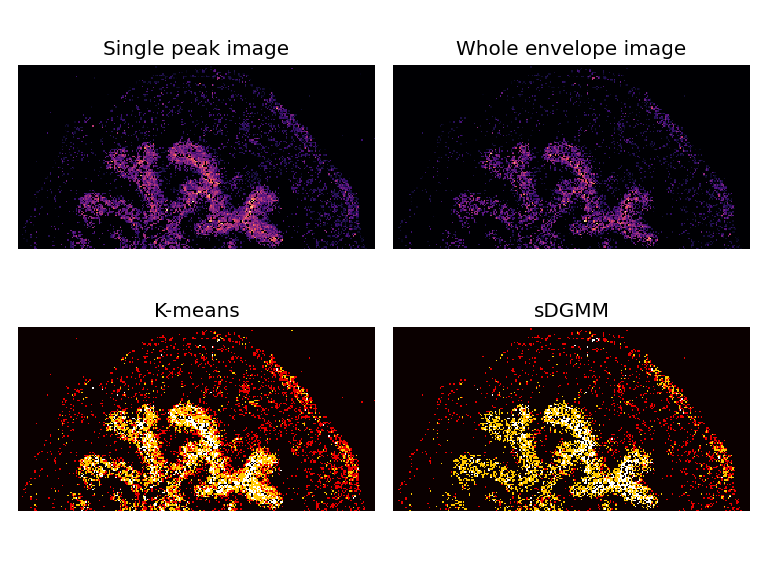

In [40]:
test_image_name = 'bladder'
lipid_id = 42
test_kmeans = np.zeros(image_shapes[test_image_name])
test_sdgmm = np.zeros(image_shapes[test_image_name])
test_masserstein = np.zeros(image_shapes[test_image_name])
test_intensity = np.zeros(image_shapes[test_image_name])

for i, l in enumerate(masserstein_coordinates[test_image_name]):
    # test_sdgmm[l[0], l[1]] = masserstein_segmentation[test_image_name][i, lipid_id]
    test_sdgmm[l[0], l[1]] = masserstein_segmentation[test_image_name][i, lipid_id]
    test_masserstein[l[0], l[1]] = masserstein_estimation[test_image_name][i, lipid_id]
    
for i, l in enumerate(intensity_coordinates[test_image_name]):
    test_kmeans[l[0], l[1]] =  intensity_segmentation[test_image_name][i, lipid_id]
    test_intensity[l[0], l[1]] = single_peak_intensities[test_image_name][i, lipid_id]
        
plt.figure()
plt.subplot(221)
plt.title('Single peak image')
plt.imshow(test_intensity, interpolation='none', cmap=cm.magma)
plt.axis('off')
plt.subplot(222)
plt.title('Whole envelope image')
plt.imshow(test_masserstein, interpolation='none', cmap=cm.magma)
plt.axis('off')
plt.subplot(223)
plt.title('K-means')
plt.imshow(test_kmeans, interpolation='none', cmap=cm.hot)
plt.axis('off')
plt.subplot(224)
plt.title('sDGMM')
plt.imshow(test_sdgmm, interpolation='none', cmap=cm.hot)
plt.axis('off')
plt.tight_layout()

## Saving the results

Save the K-means segmentation results:

In [41]:
for n in image_names:
    with open(n + '_kmeans.tsv', 'w') as h:
        sgm_table = intensity_segmentation[n]
        crd = intensity_coordinates[n]
        header = ['X', 'Y'] + list(map(str, range(sgm_table.shape[1])))
        h.write('\t'.join(header) + '\n')
        for l1, l2 in zip(crd, sgm_table):
            l1 = '\t'.join(list(map(str, l1)))
            l2 = '\t'.join(list(map(str, l2)))
            h.write(l1 + '\t' + l2 + '\n')

Save the spatial-DGMM segmentation results:

In [42]:
for n in image_names:
    with open(n + '_sdgmm.tsv', 'w') as h:
        sgm_table = masserstein_segmentation[n]
        crd = masserstein_coordinates[n]
        header = ['X', 'Y'] + list(map(str, range(sgm_table.shape[1])))
        h.write('\t'.join(header) + '\n')
        for l1, l2 in zip(crd, sgm_table):
            l1 = '\t'.join(list(map(str, l1)))
            l2 = '\t'.join(list(map(str, l2)))
            h.write(l1 + '\t' + l2 + '\n')

Now, generate and save images and segmentations for each lipid:

<IPython.core.display.Javascript object>


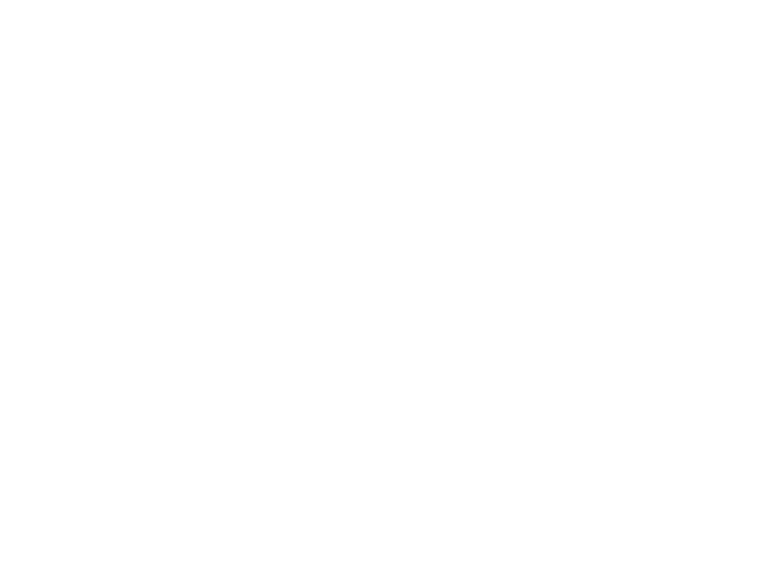

<IPython.core.display.Javascript object>


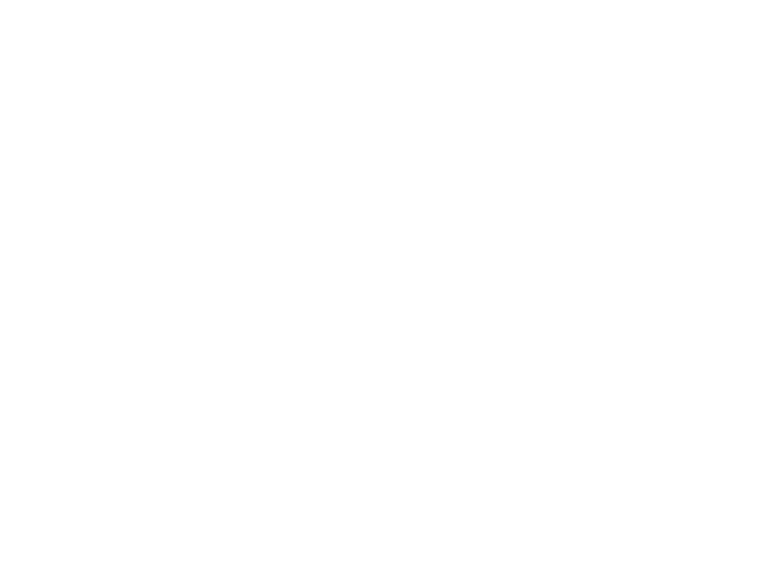

<IPython.core.display.Javascript object>


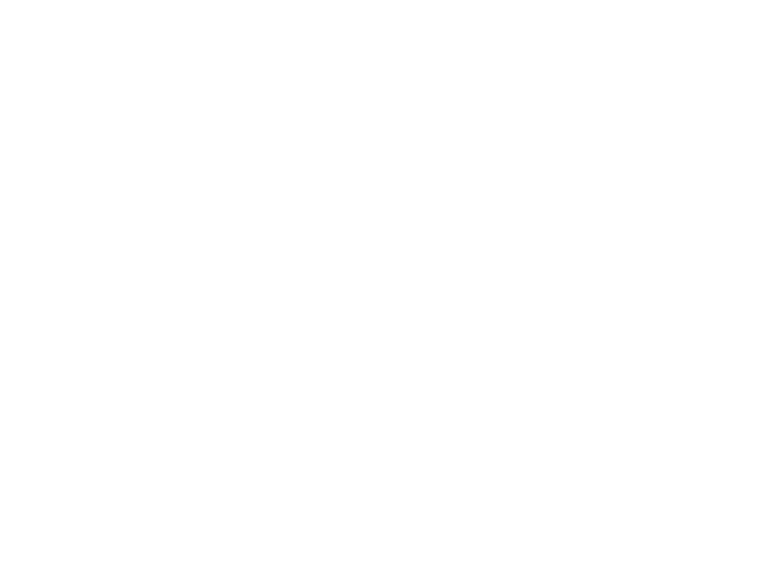

<IPython.core.display.Javascript object>


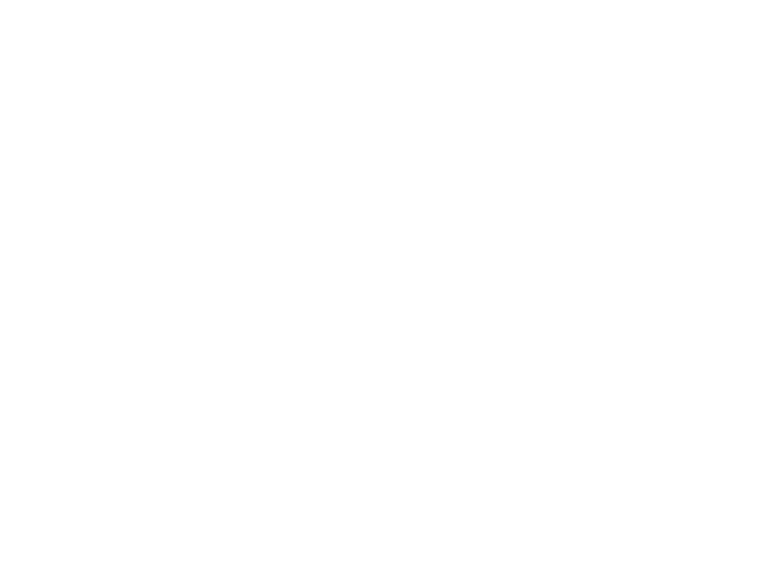

<IPython.core.display.Javascript object>


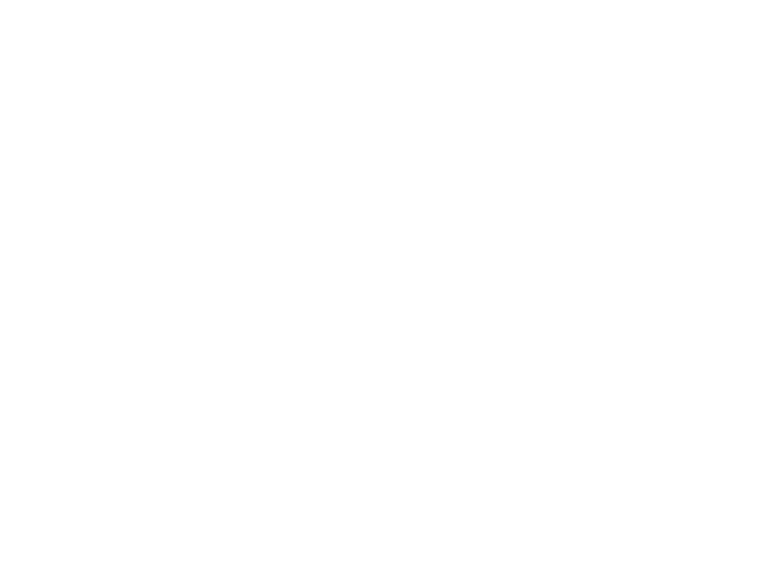

<IPython.core.display.Javascript object>


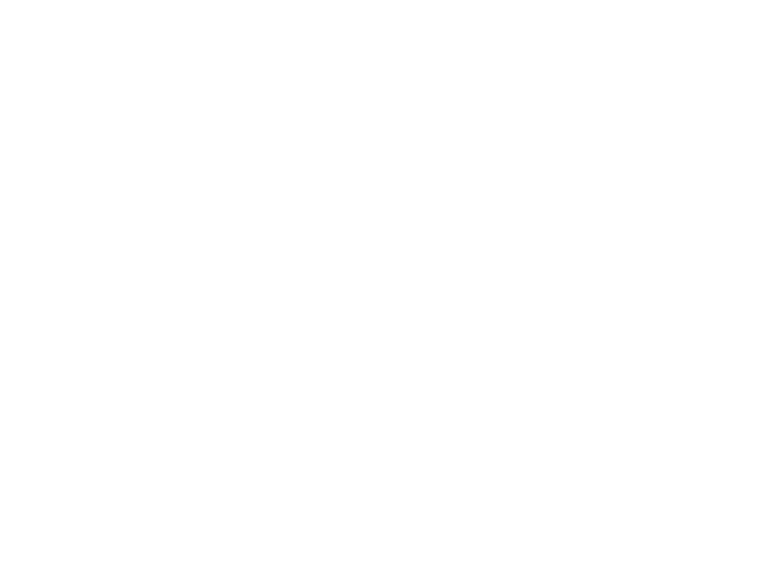

<IPython.core.display.Javascript object>


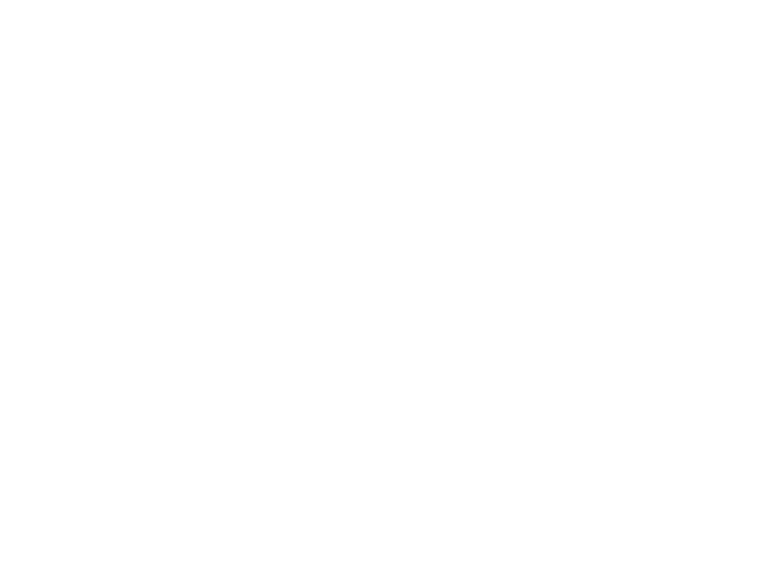

<IPython.core.display.Javascript object>


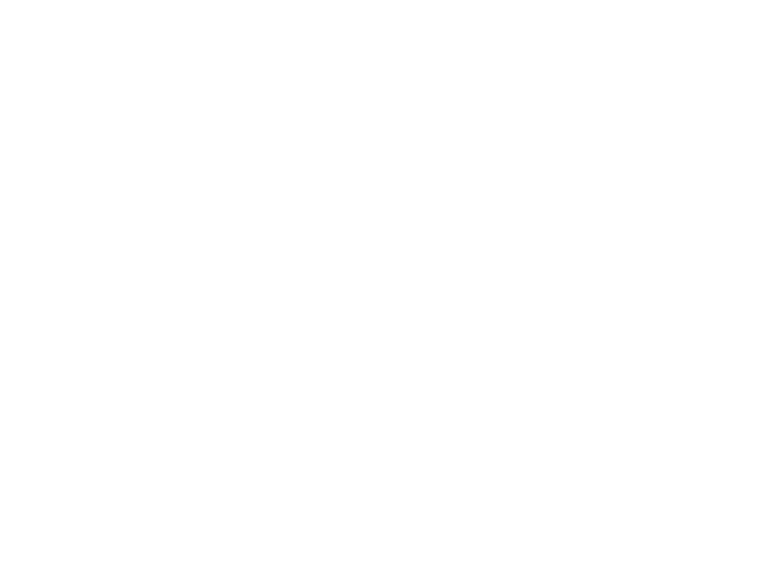

<IPython.core.display.Javascript object>


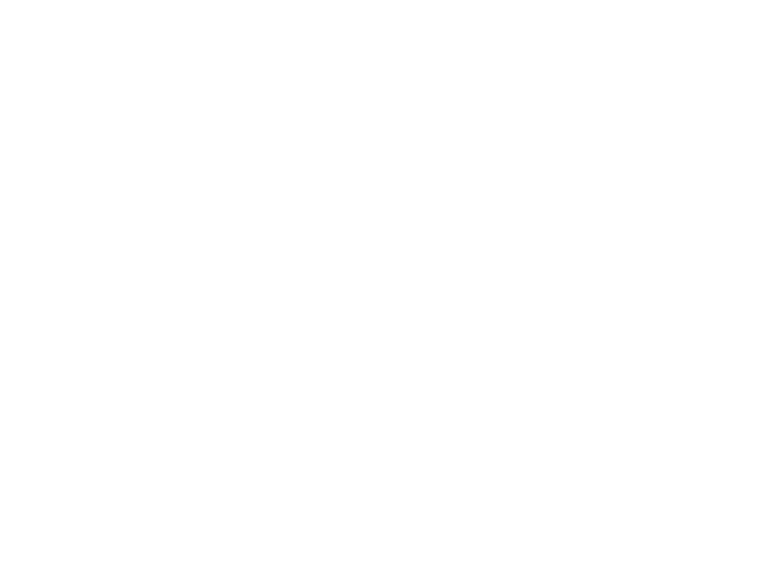

<IPython.core.display.Javascript object>


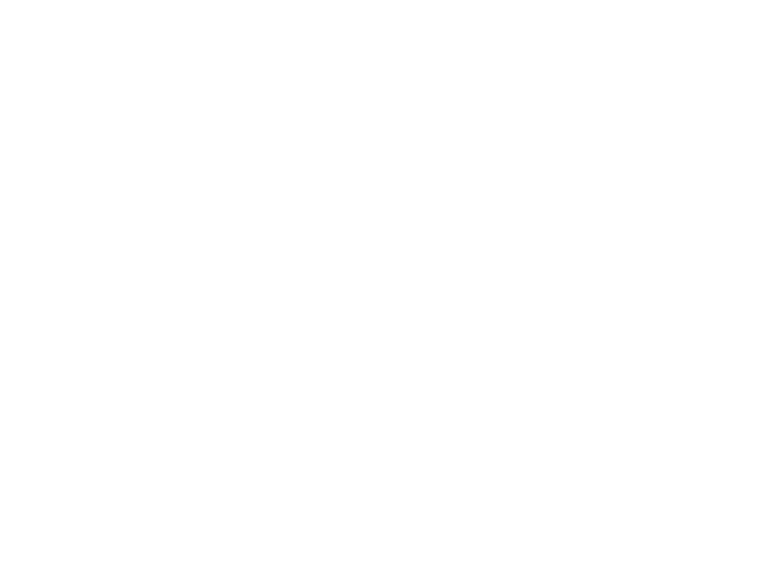

<IPython.core.display.Javascript object>


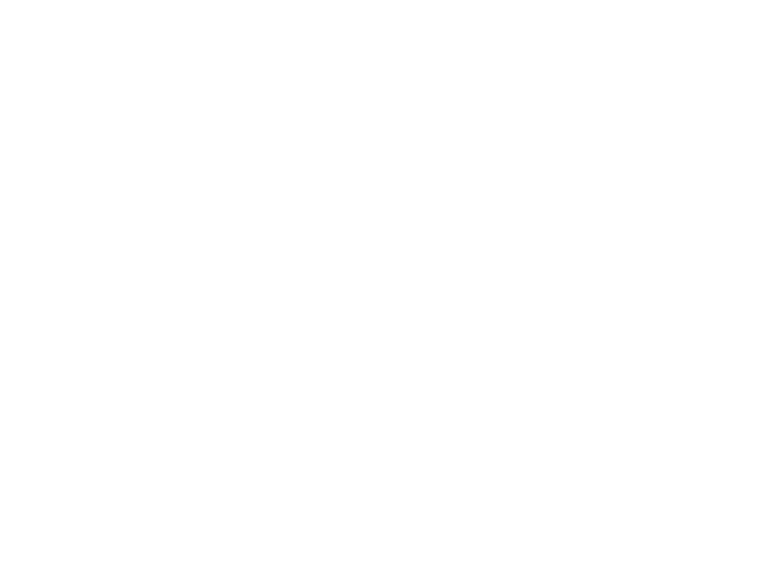

<IPython.core.display.Javascript object>


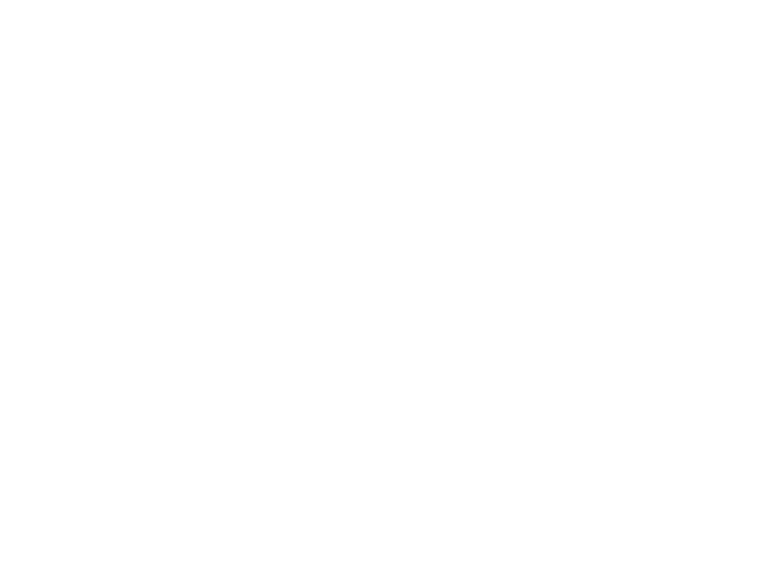

<IPython.core.display.Javascript object>


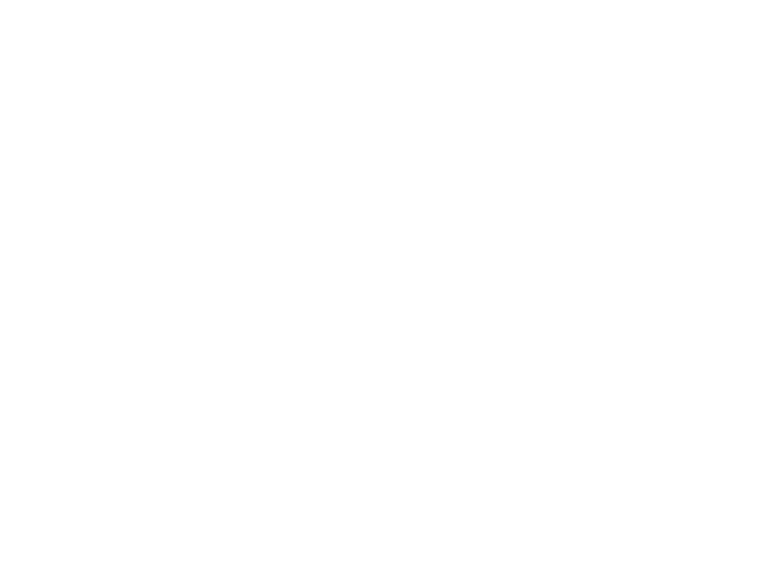

<IPython.core.display.Javascript object>


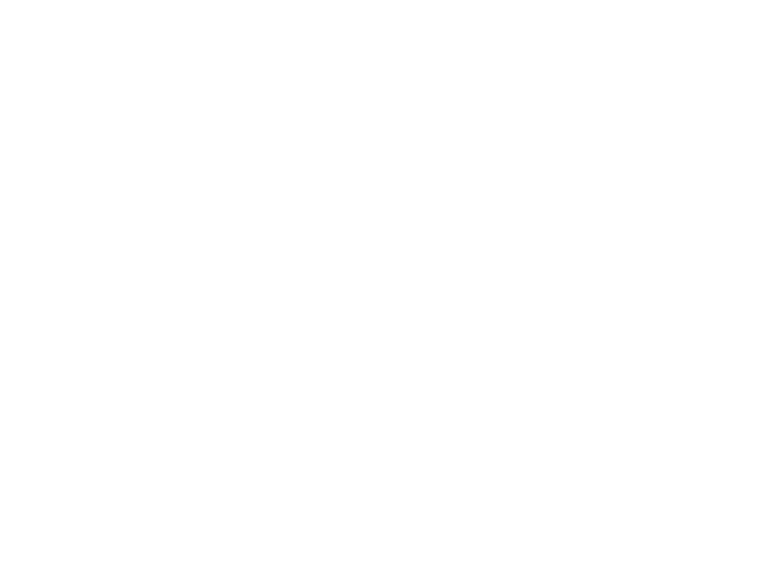

<IPython.core.display.Javascript object>


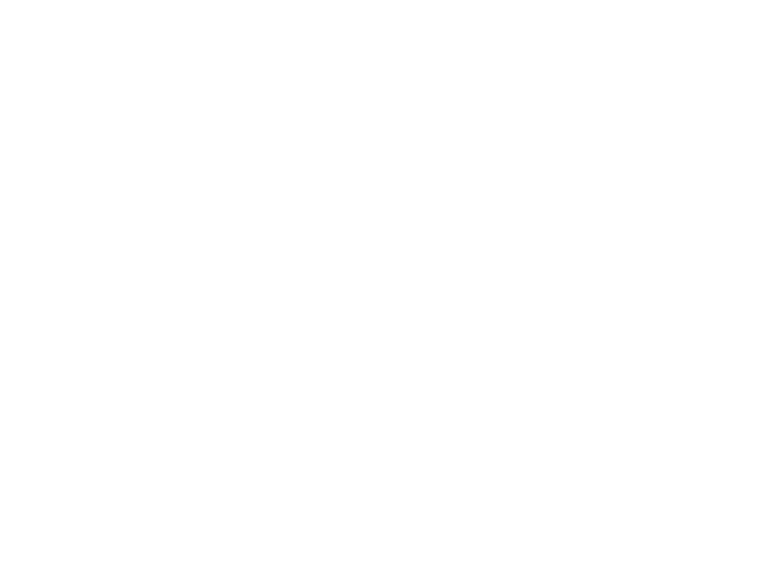

<IPython.core.display.Javascript object>


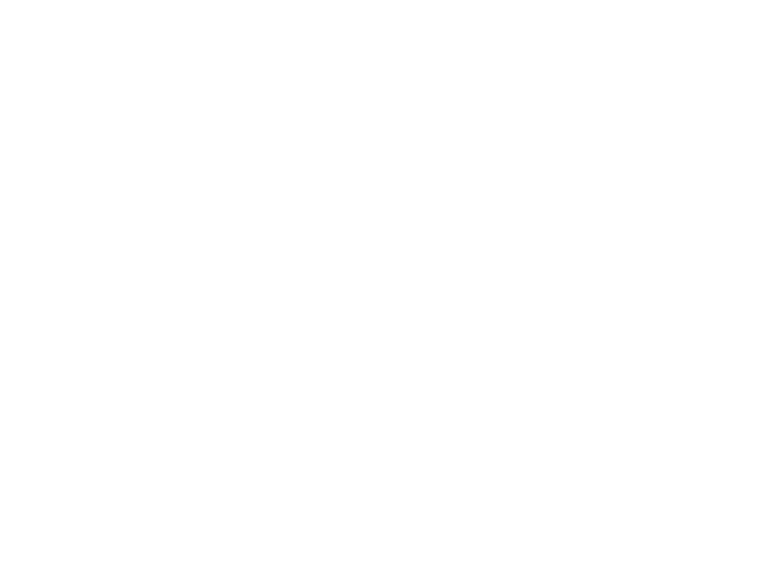

<IPython.core.display.Javascript object>


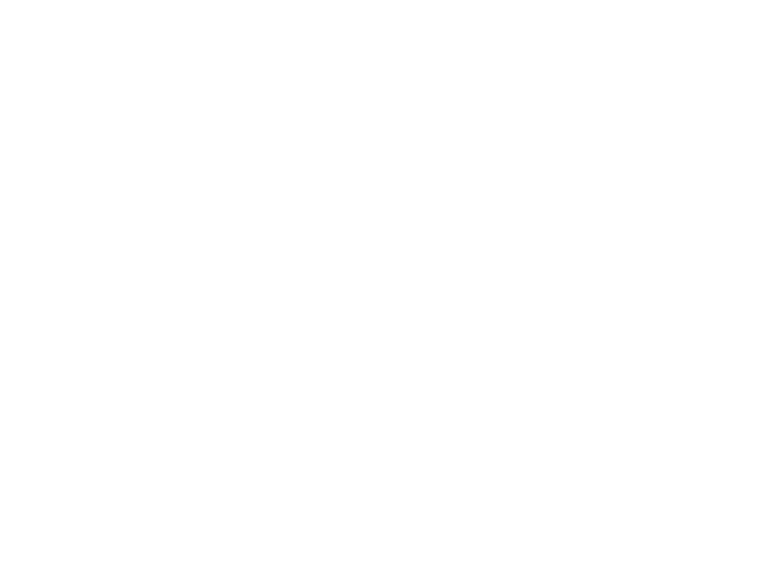

<IPython.core.display.Javascript object>


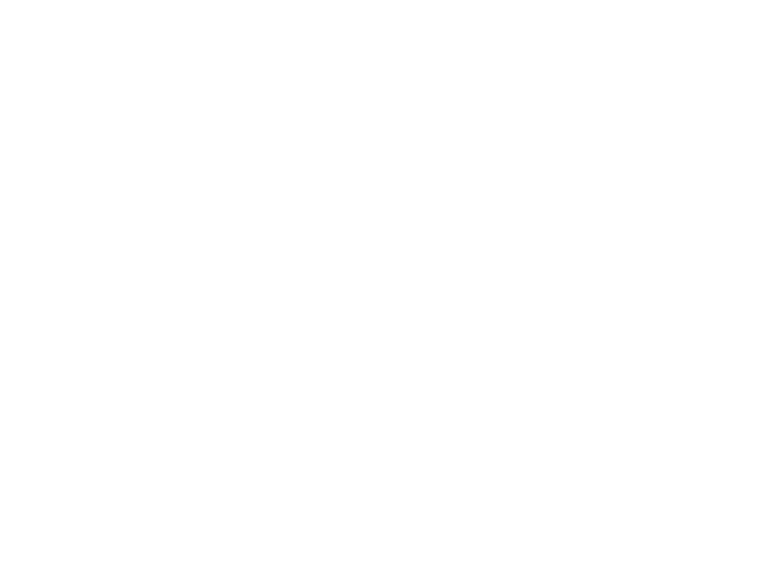

<IPython.core.display.Javascript object>


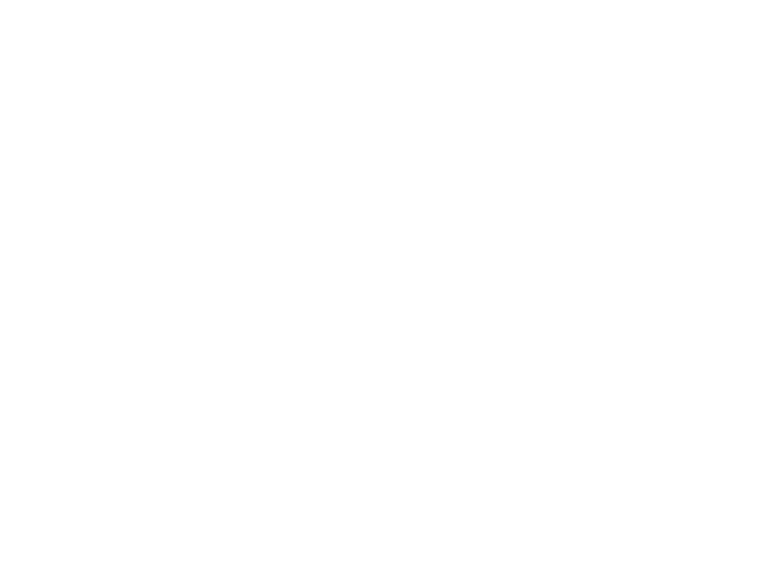

<IPython.core.display.Javascript object>


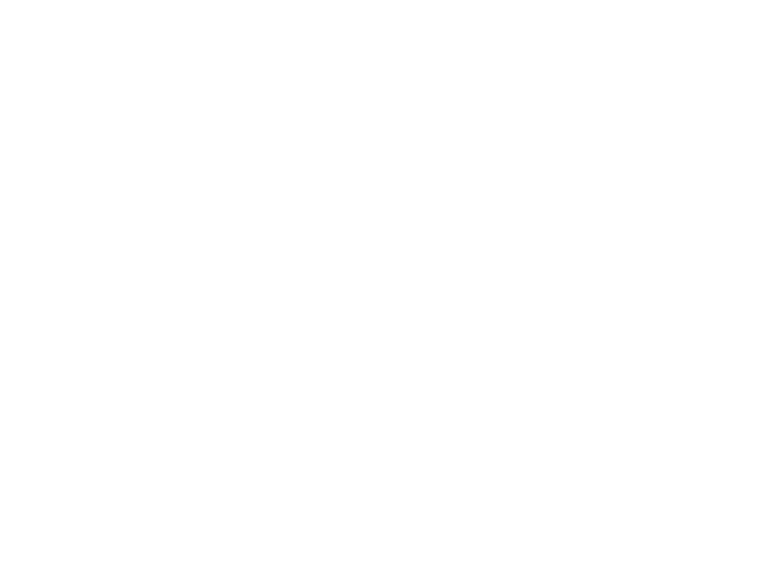

<IPython.core.display.Javascript object>


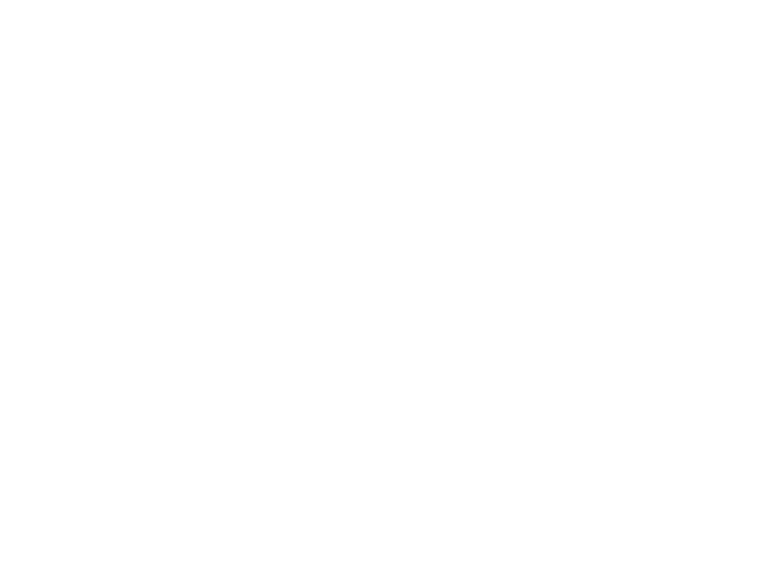

<IPython.core.display.Javascript object>


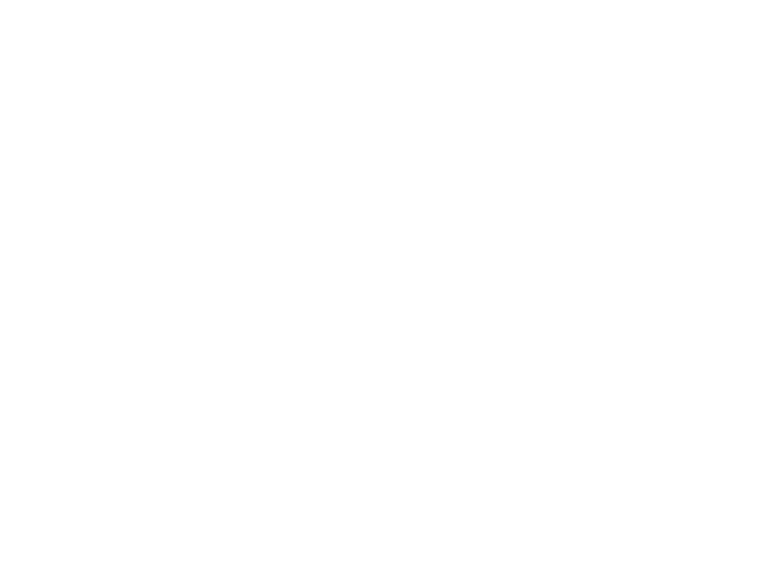

<IPython.core.display.Javascript object>


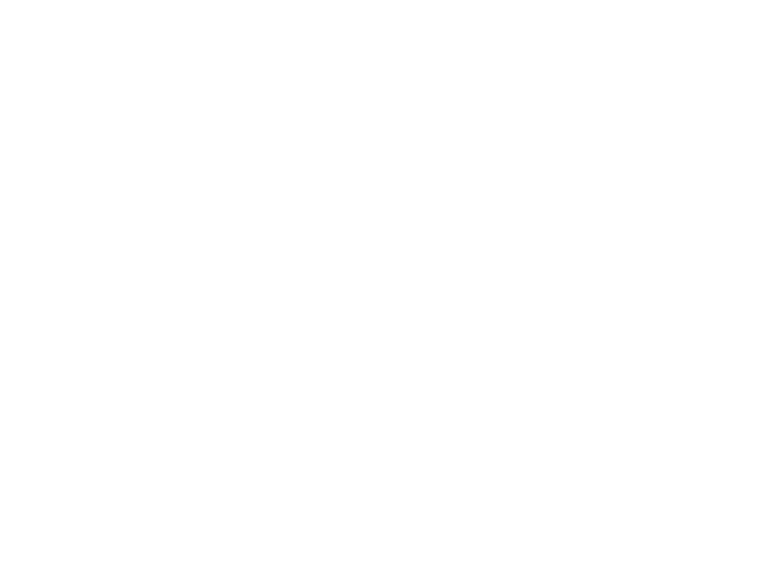

<IPython.core.display.Javascript object>


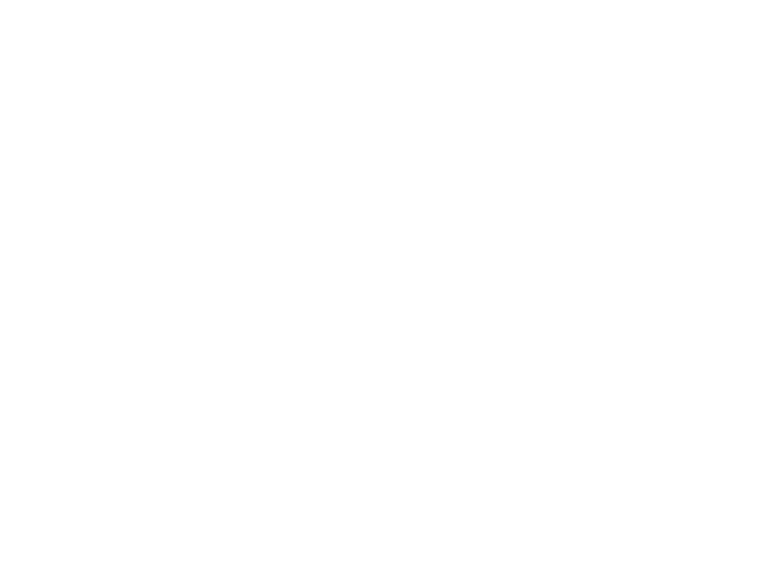

<IPython.core.display.Javascript object>


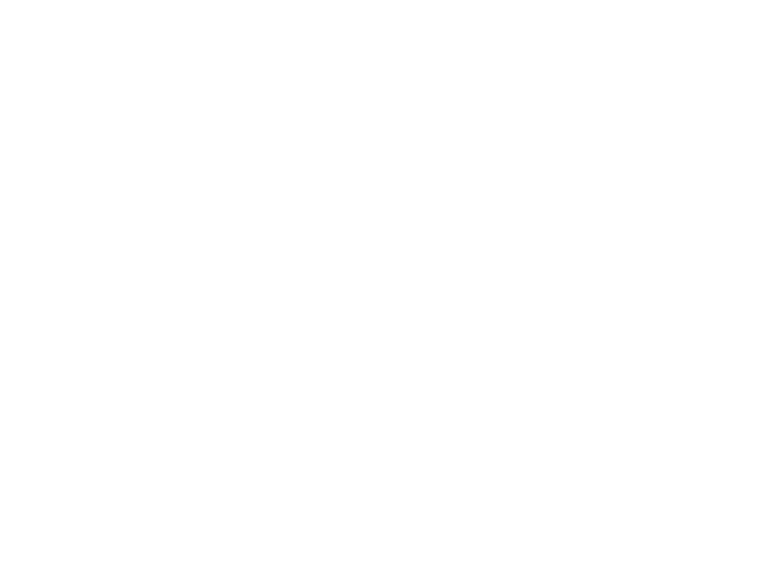

<IPython.core.display.Javascript object>


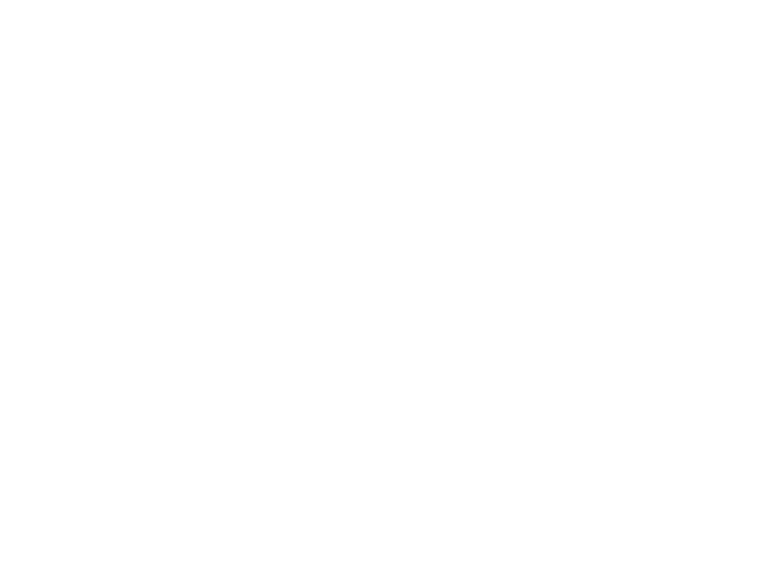

<IPython.core.display.Javascript object>


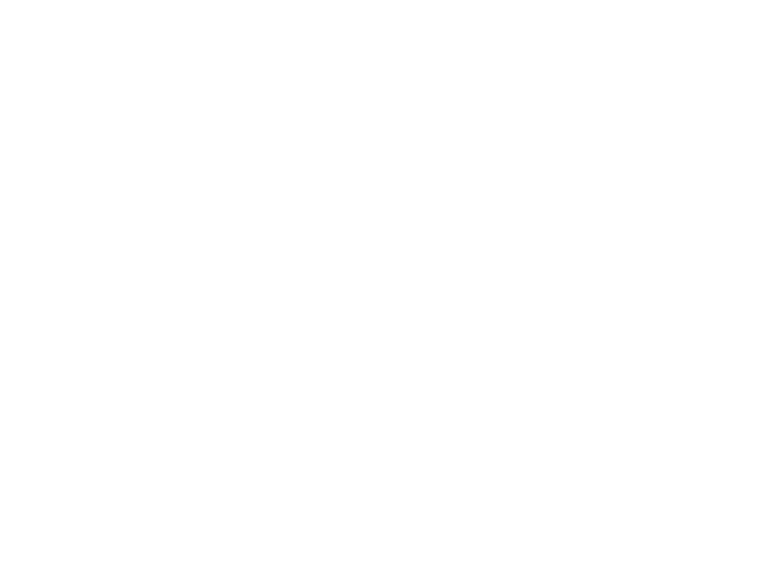

<IPython.core.display.Javascript object>


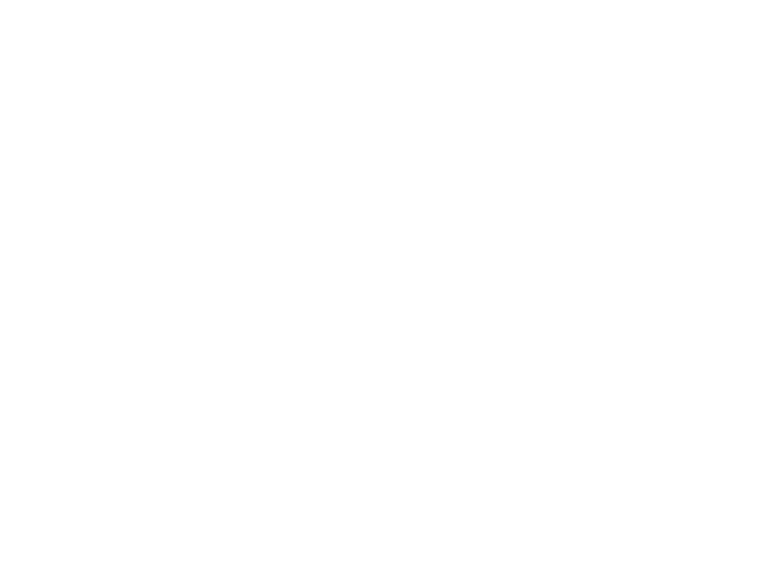

<IPython.core.display.Javascript object>


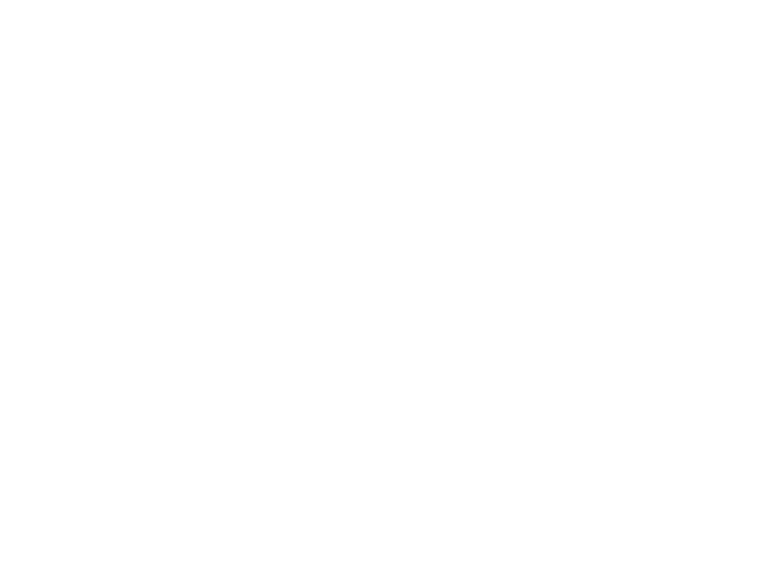

<IPython.core.display.Javascript object>


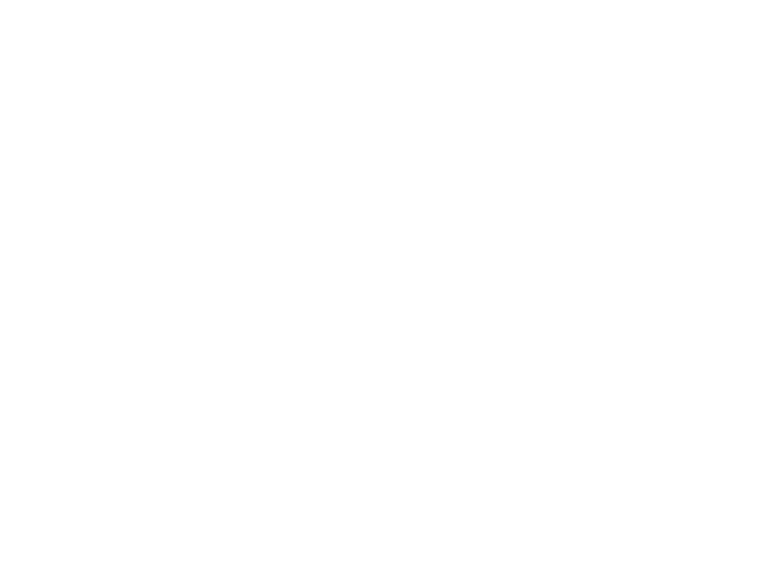

<IPython.core.display.Javascript object>


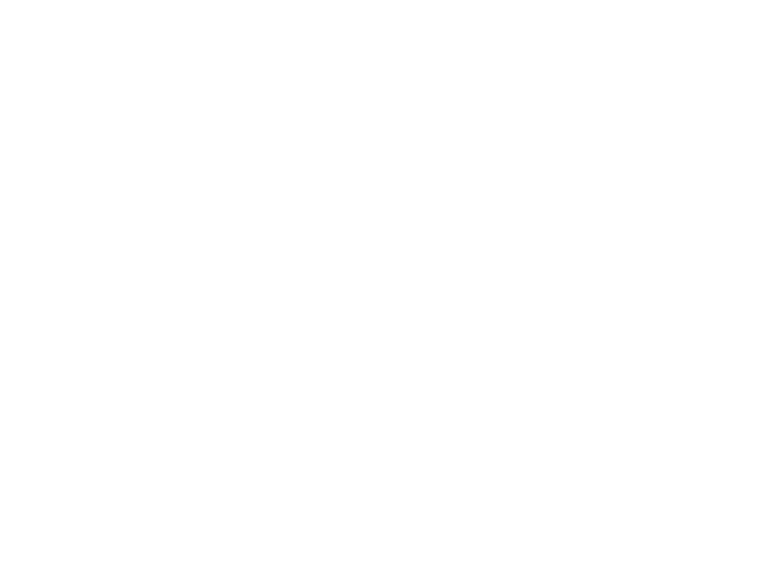

<IPython.core.display.Javascript object>


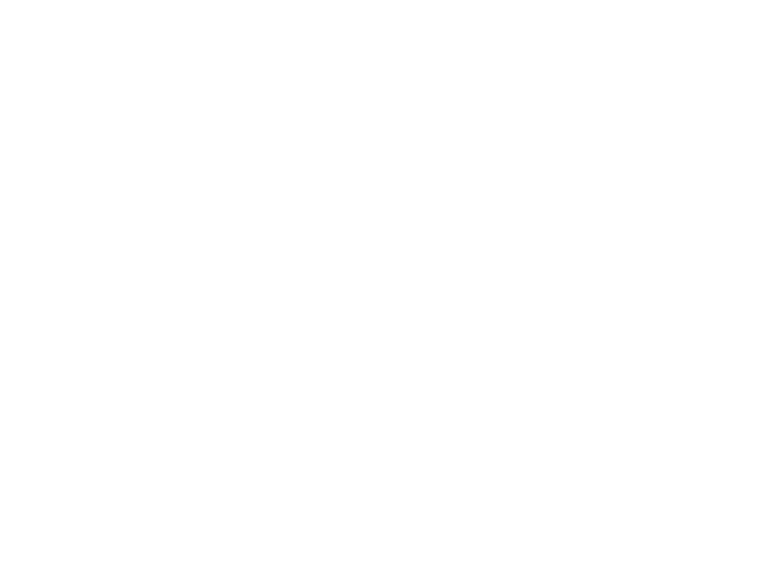

<IPython.core.display.Javascript object>


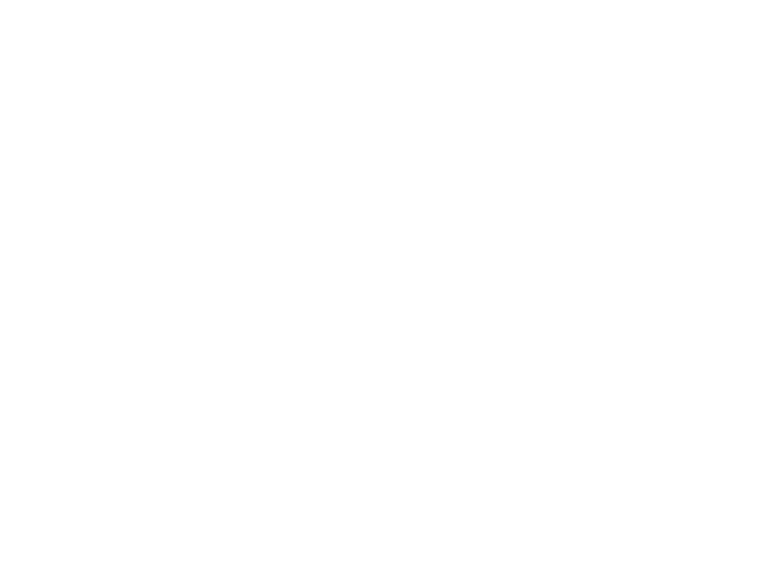

<IPython.core.display.Javascript object>


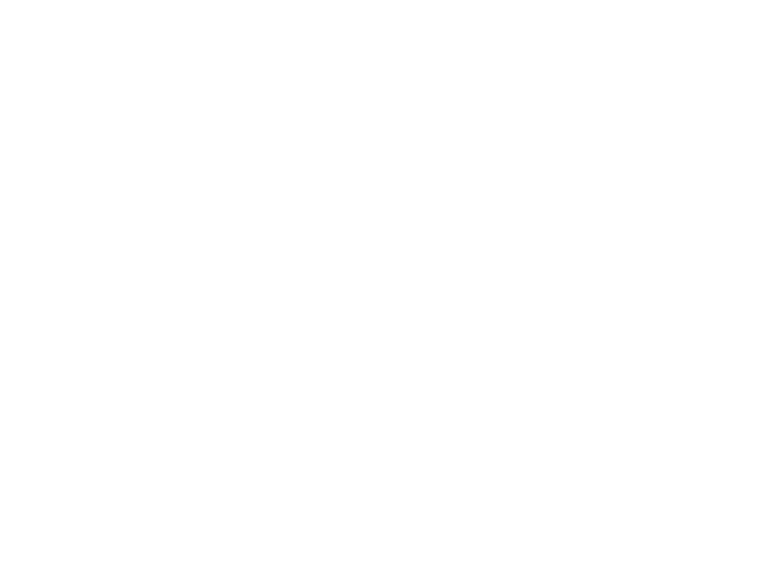

<IPython.core.display.Javascript object>


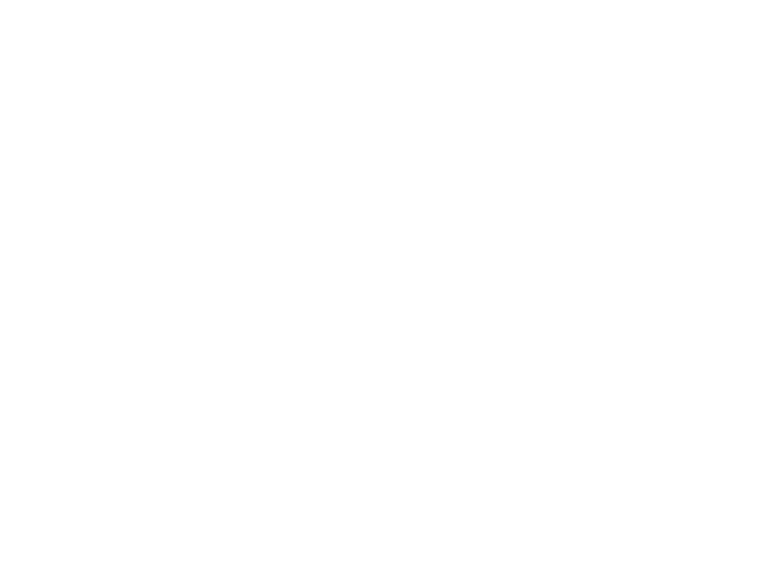

<IPython.core.display.Javascript object>


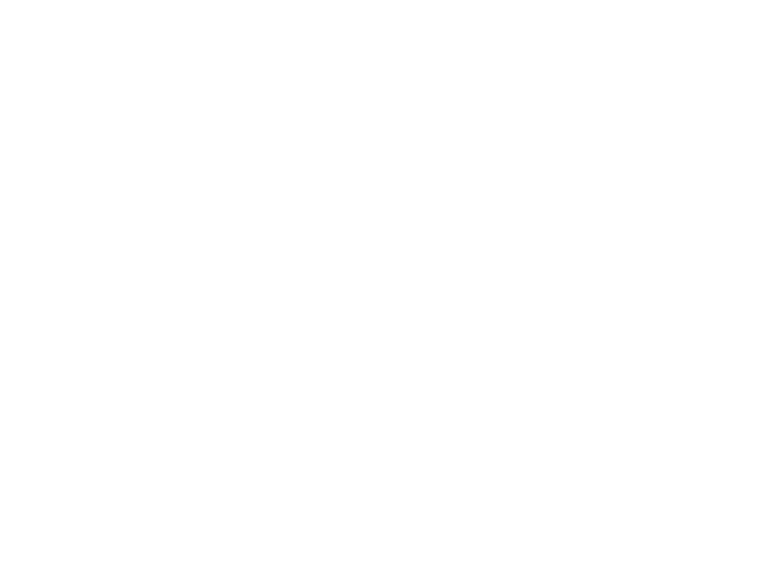

<IPython.core.display.Javascript object>


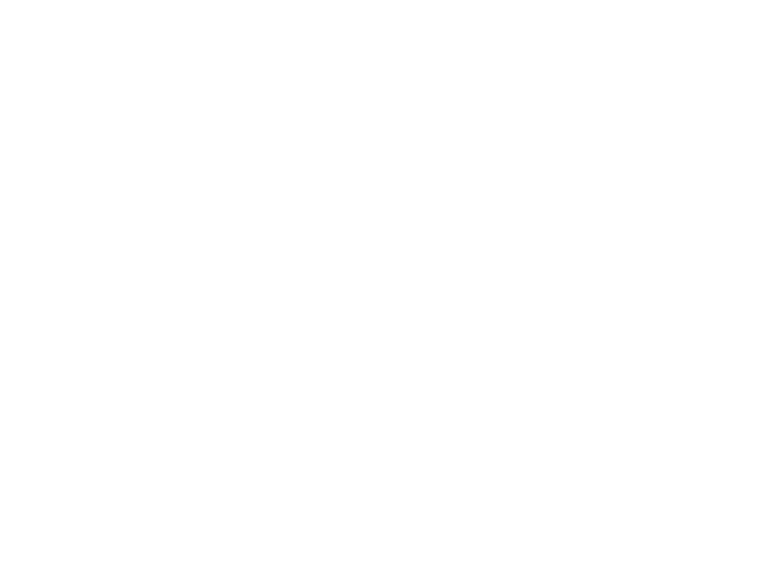

<IPython.core.display.Javascript object>


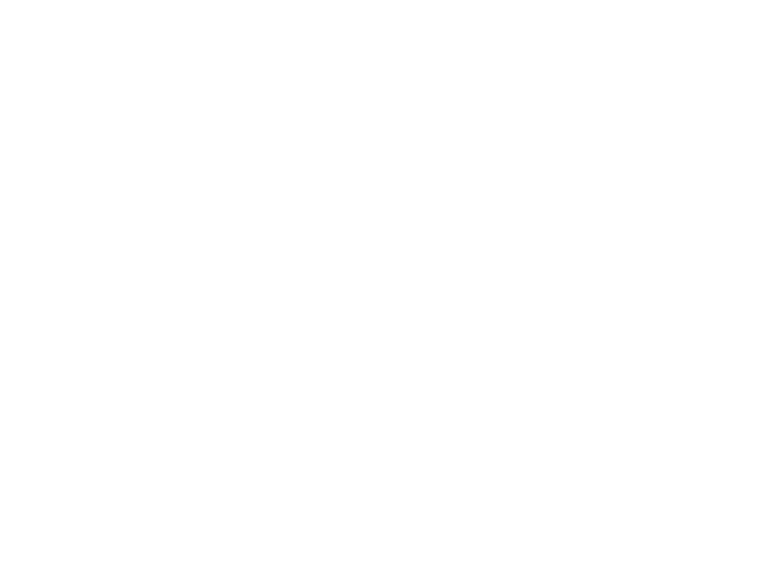

<IPython.core.display.Javascript object>


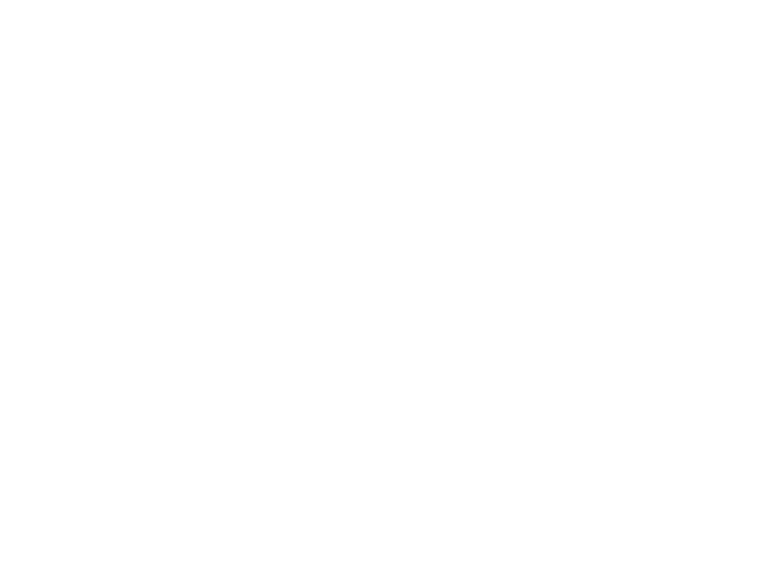

<IPython.core.display.Javascript object>


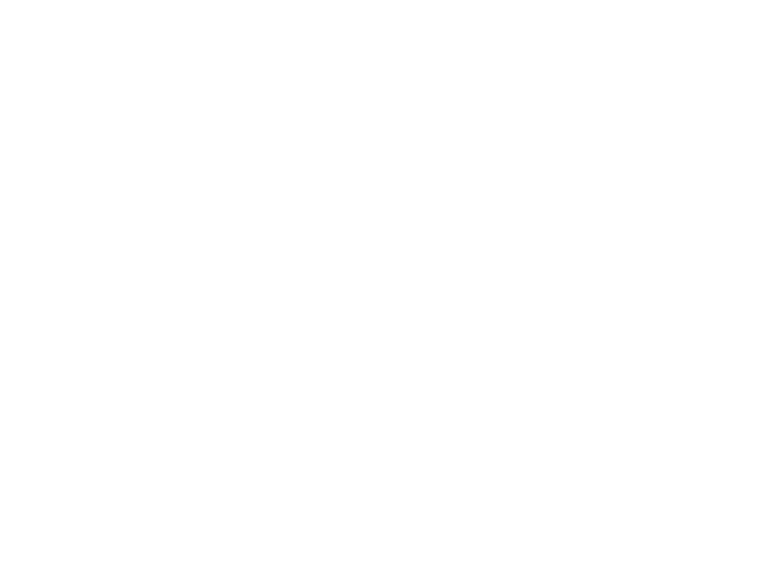

<IPython.core.display.Javascript object>


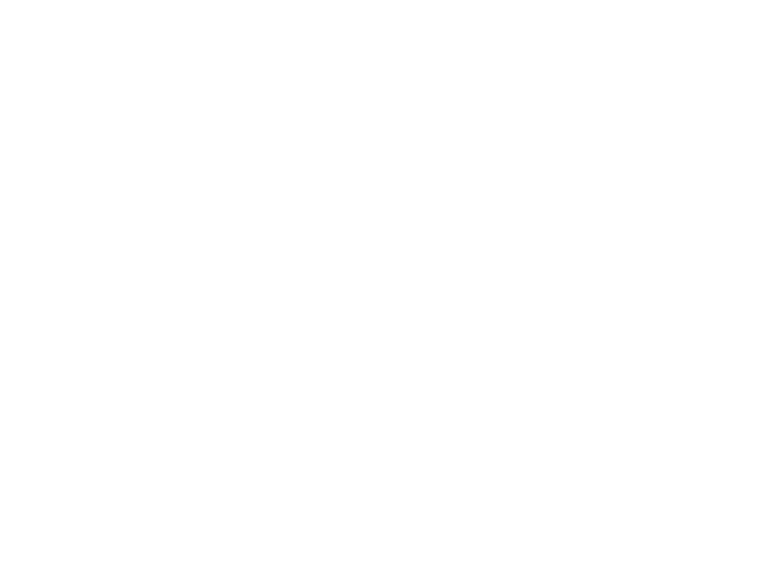

<IPython.core.display.Javascript object>


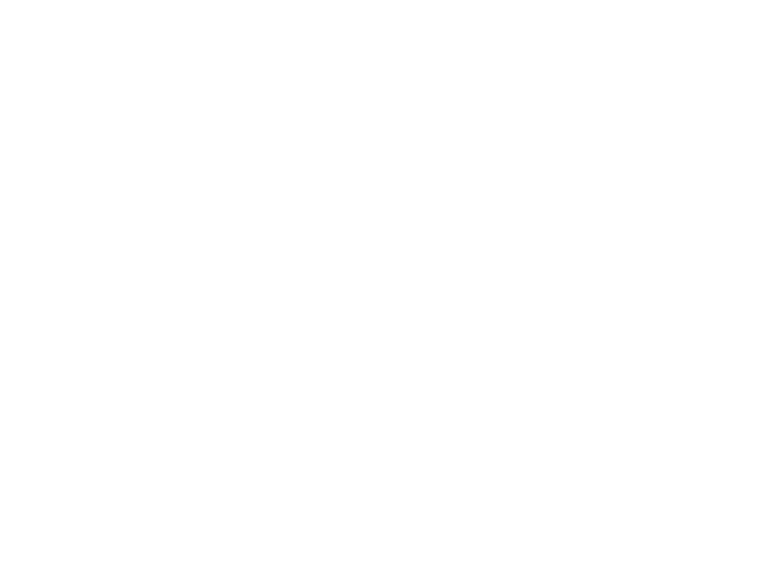

<IPython.core.display.Javascript object>


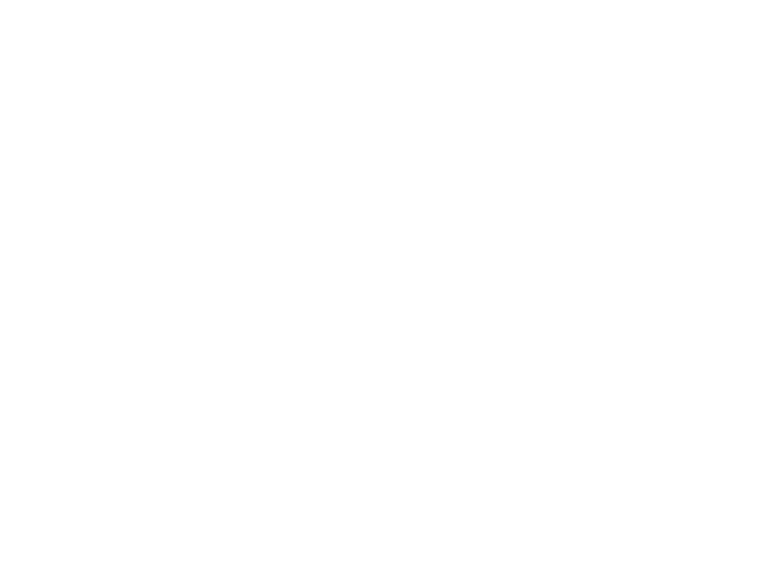

<IPython.core.display.Javascript object>


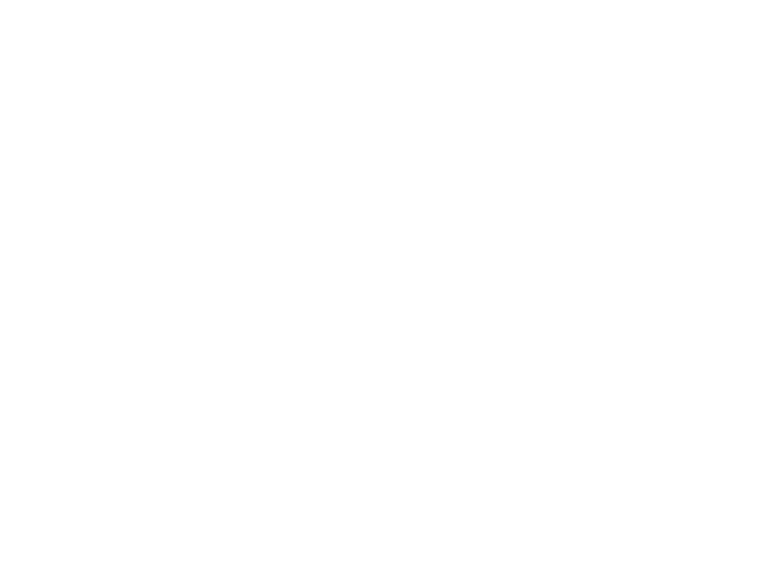

<IPython.core.display.Javascript object>


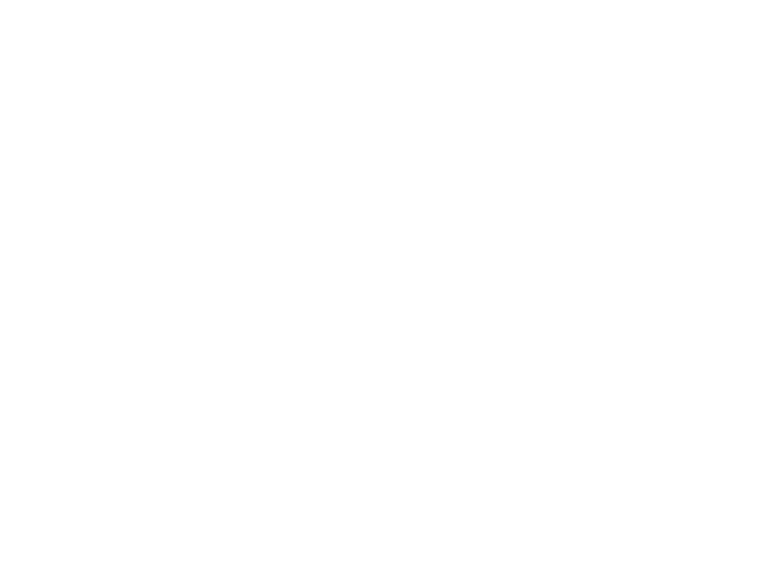

<IPython.core.display.Javascript object>


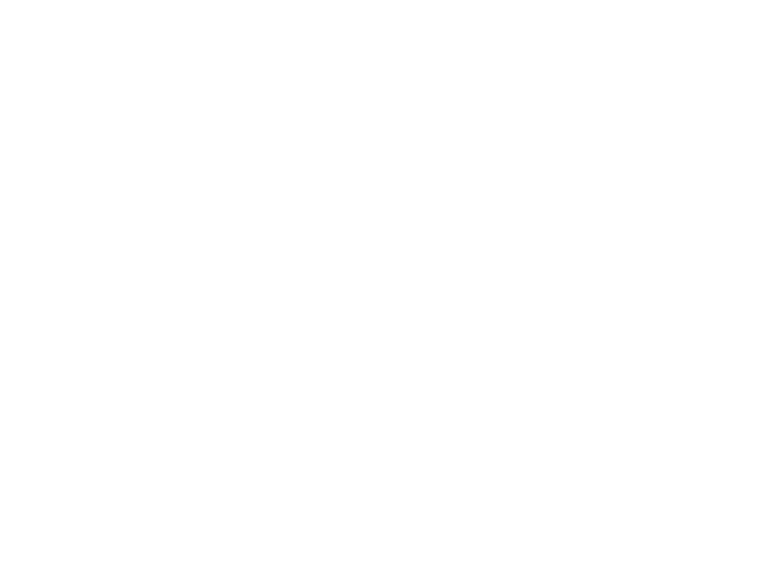

<IPython.core.display.Javascript object>


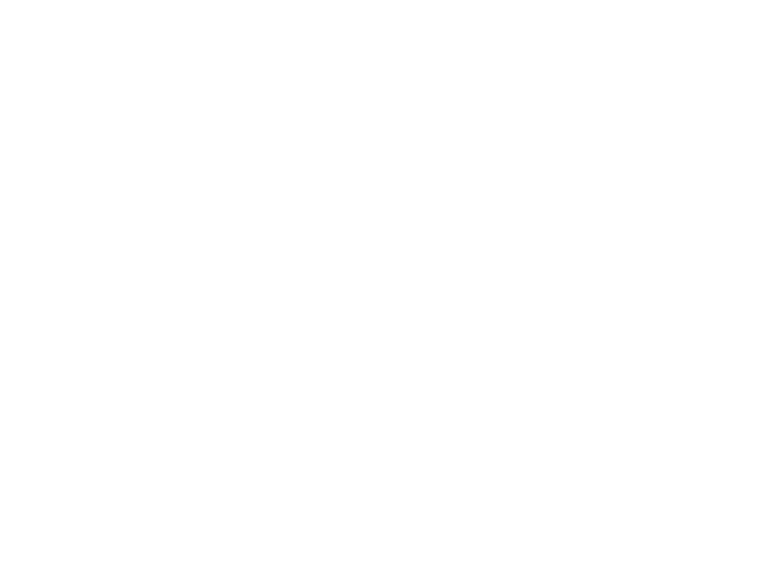

<IPython.core.display.Javascript object>


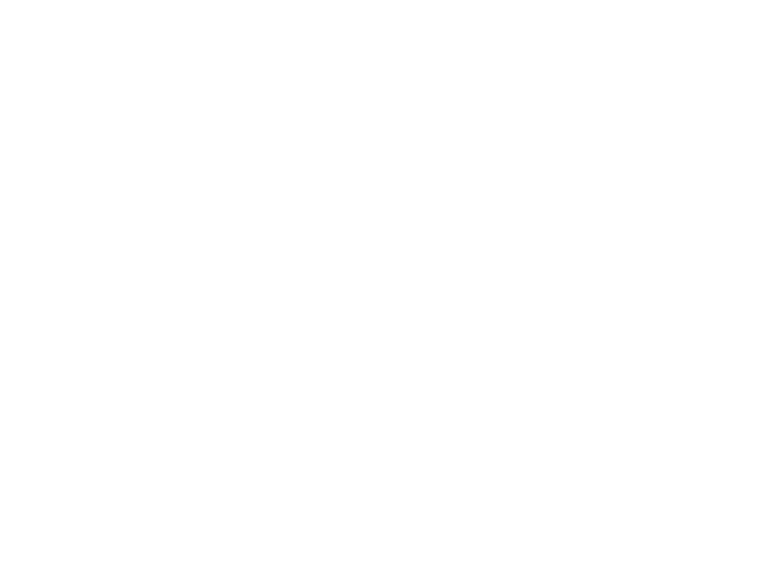

<IPython.core.display.Javascript object>


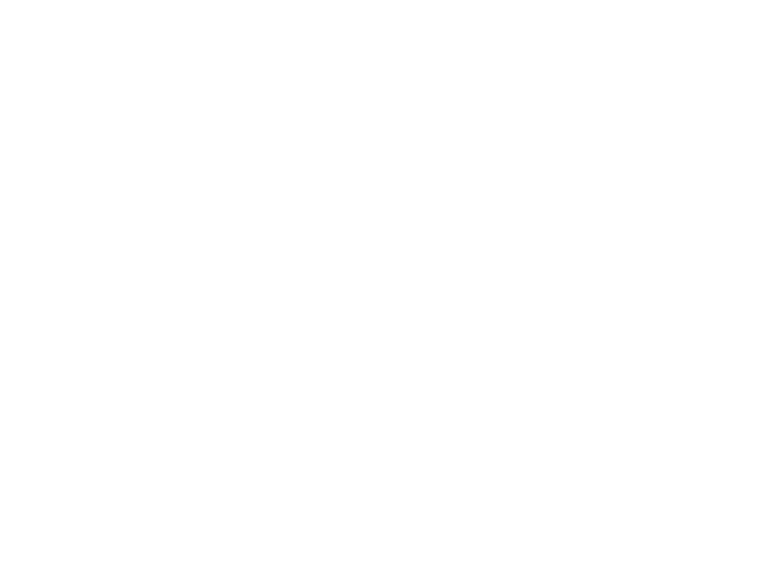

<IPython.core.display.Javascript object>


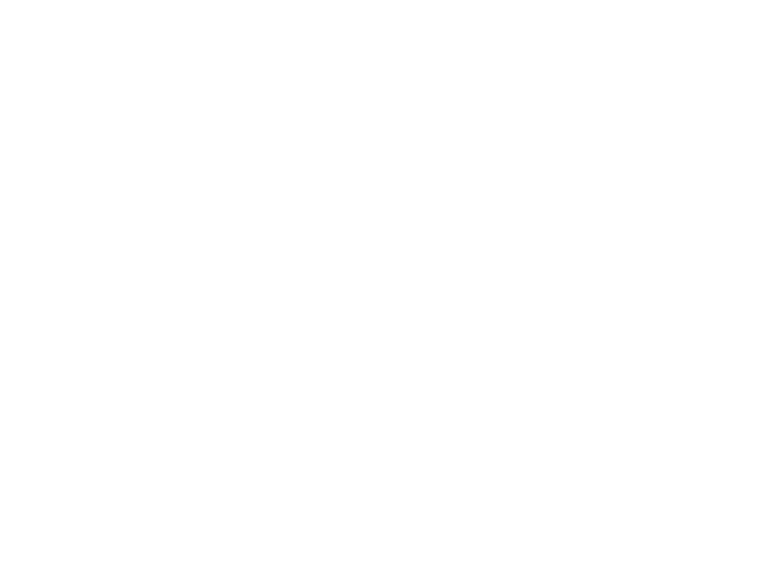

<IPython.core.display.Javascript object>


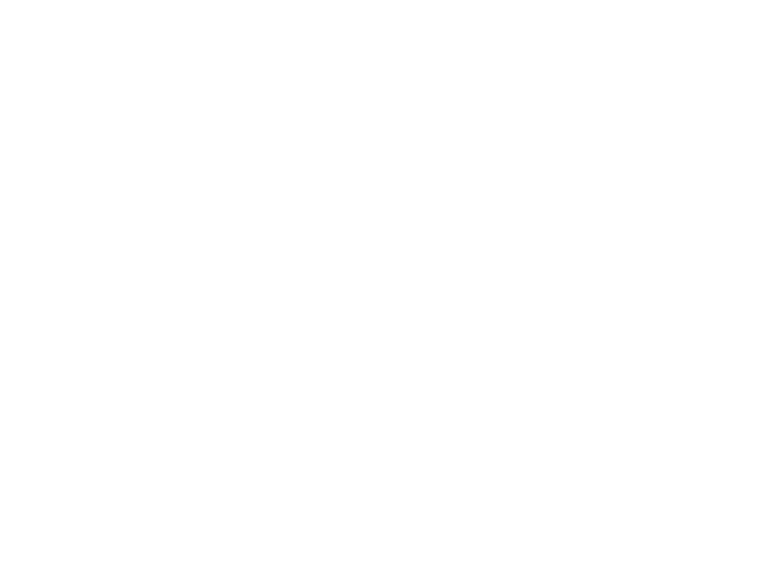

<IPython.core.display.Javascript object>


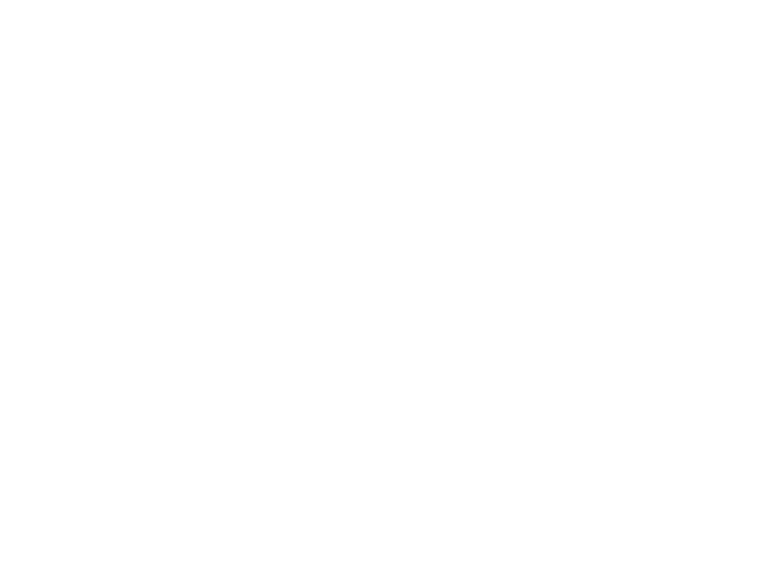

<IPython.core.display.Javascript object>


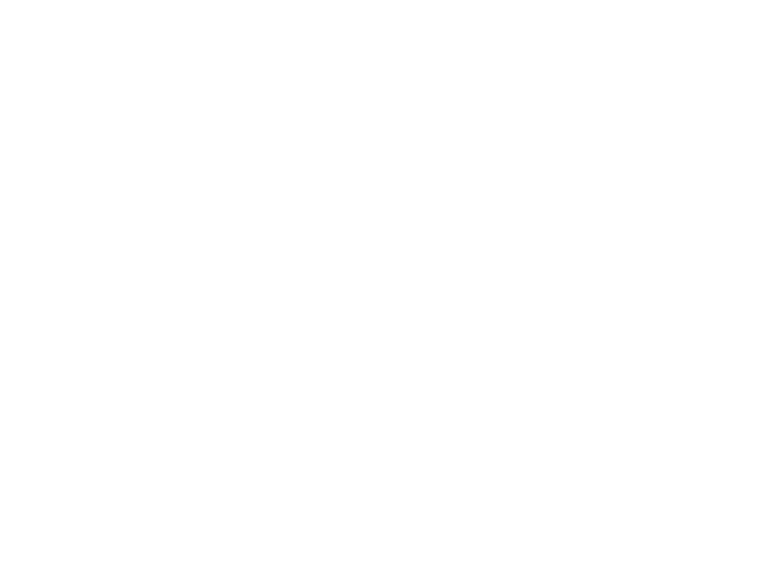

<IPython.core.display.Javascript object>


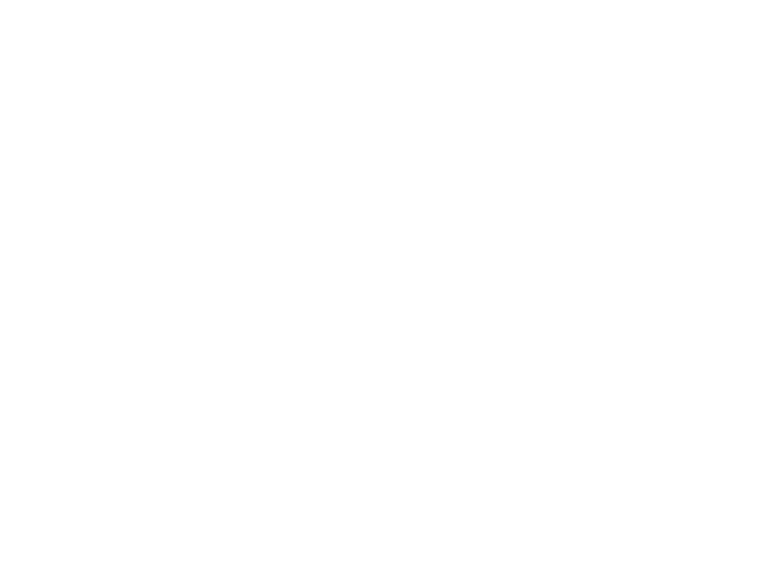

<IPython.core.display.Javascript object>


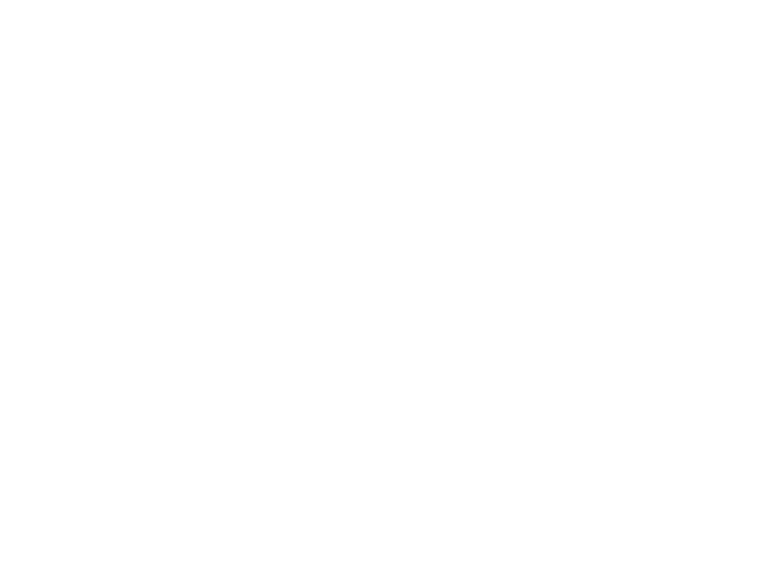

<IPython.core.display.Javascript object>


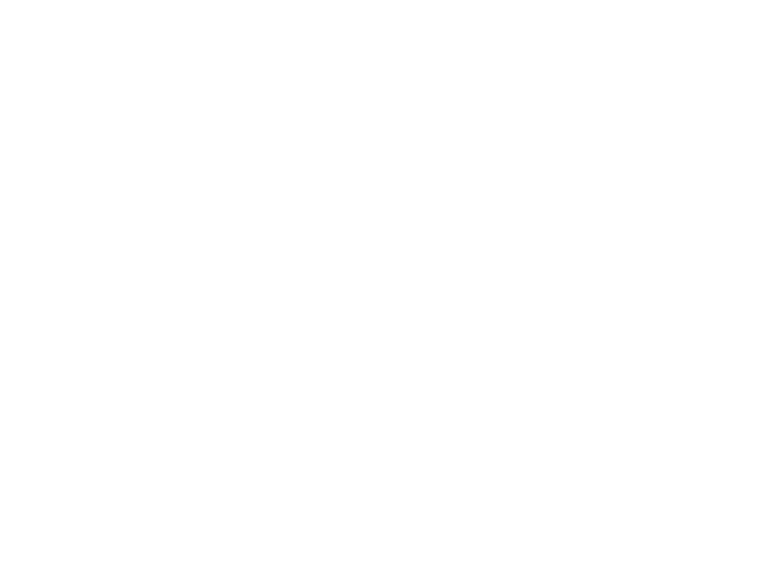

<IPython.core.display.Javascript object>


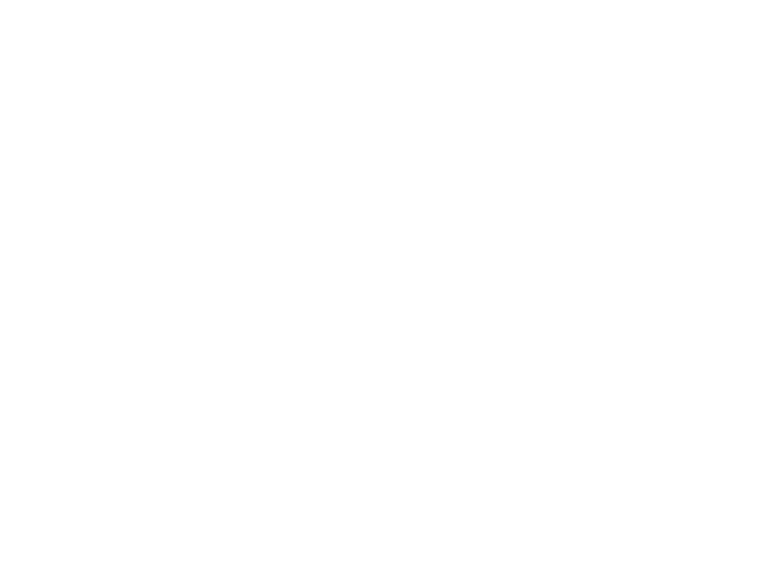

<IPython.core.display.Javascript object>


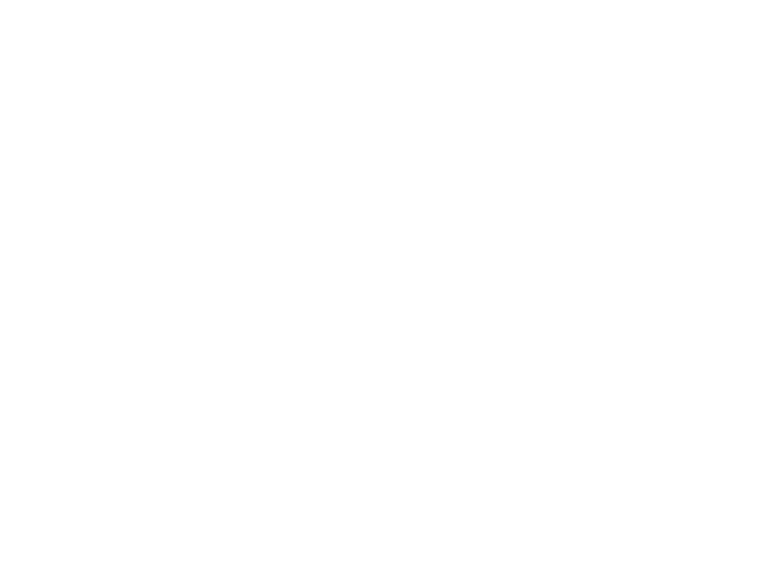

<IPython.core.display.Javascript object>


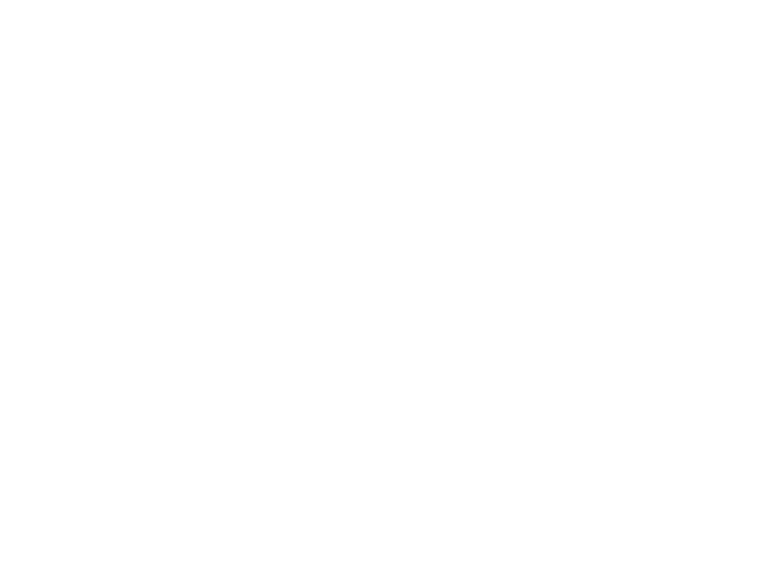

<IPython.core.display.Javascript object>


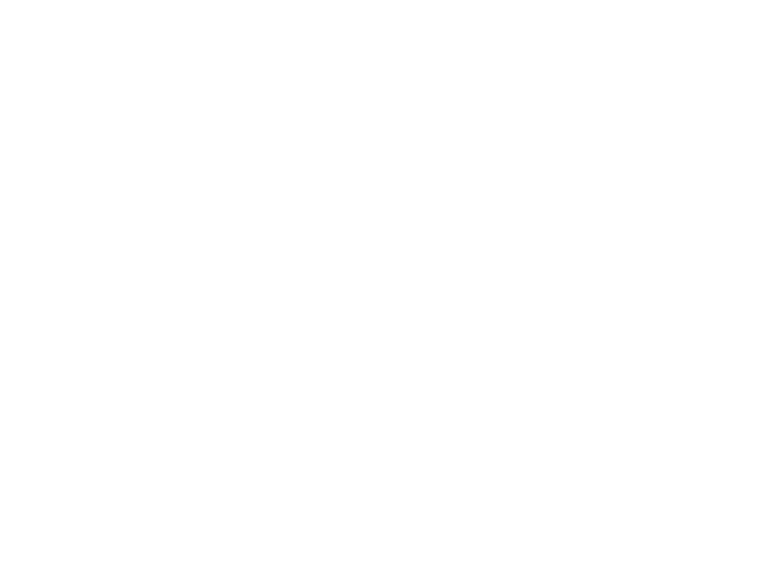

<IPython.core.display.Javascript object>


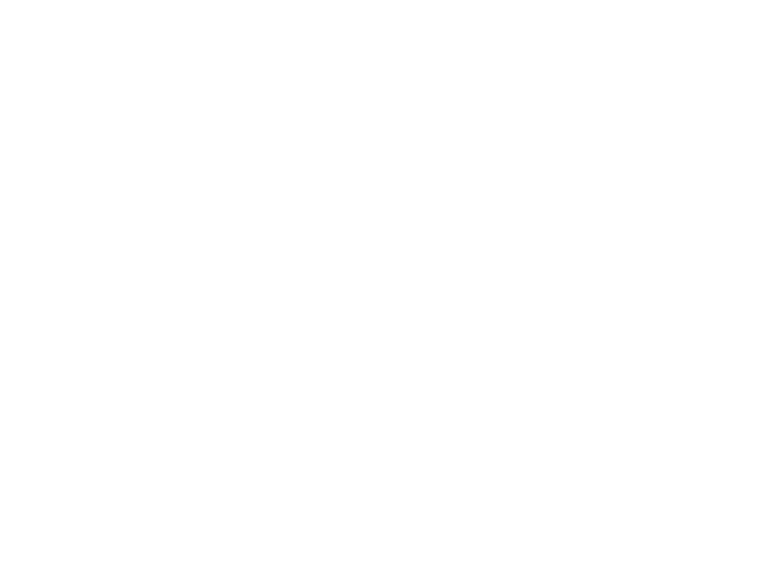

<IPython.core.display.Javascript object>


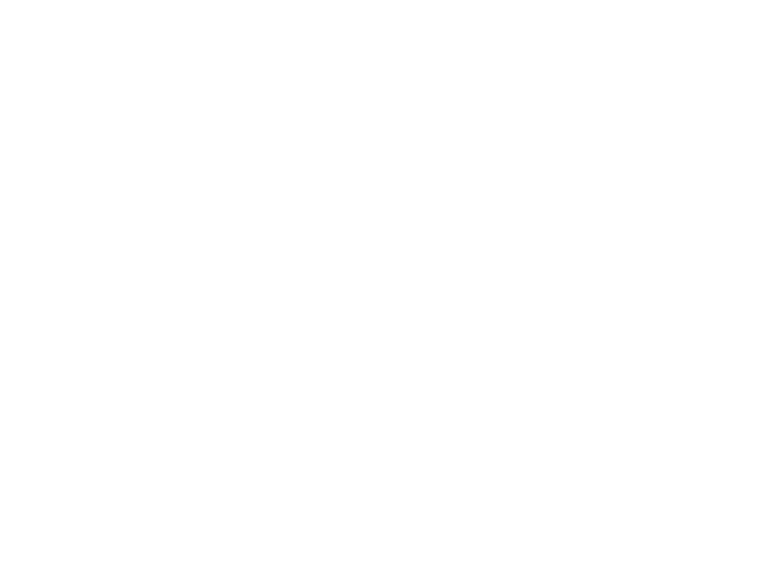

<IPython.core.display.Javascript object>


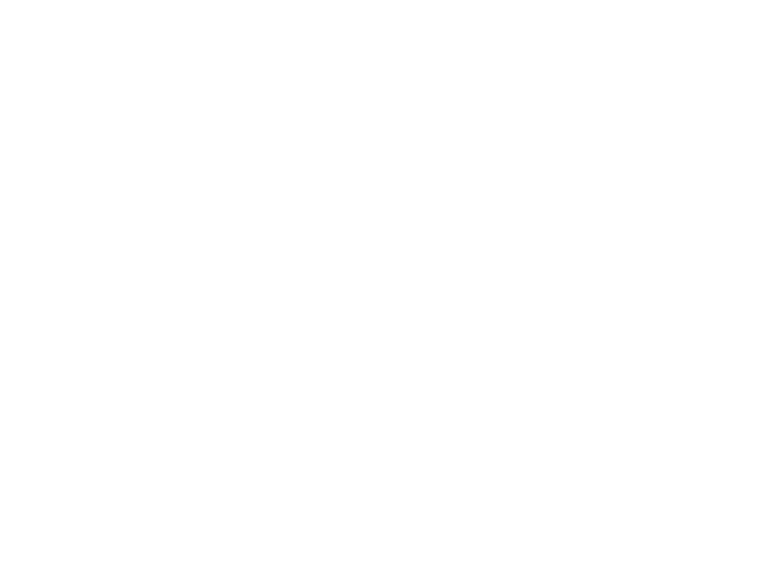

<IPython.core.display.Javascript object>


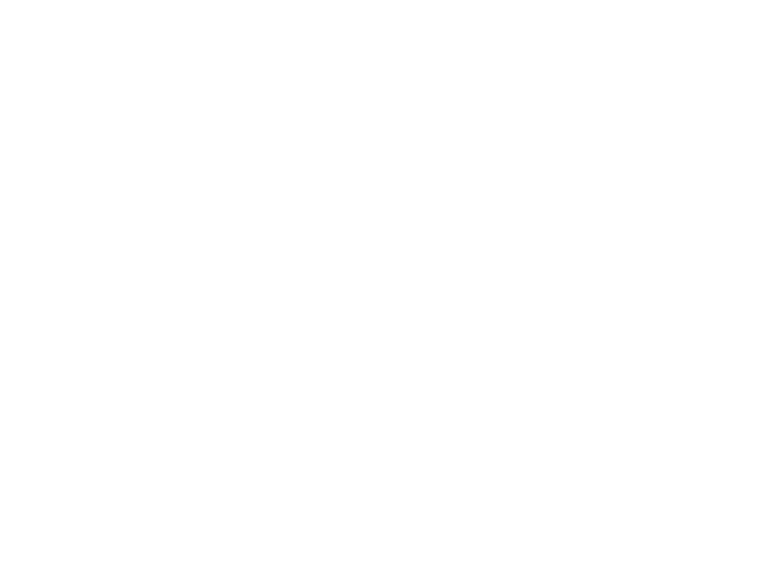

<IPython.core.display.Javascript object>


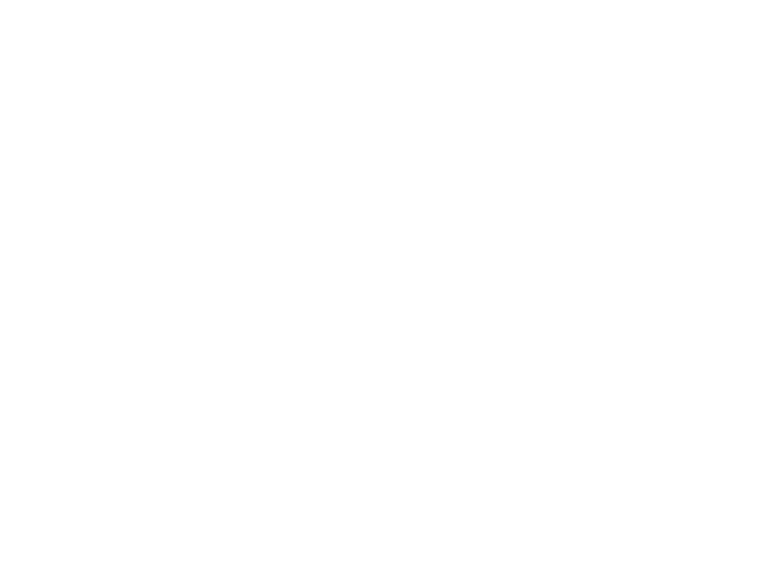

<IPython.core.display.Javascript object>


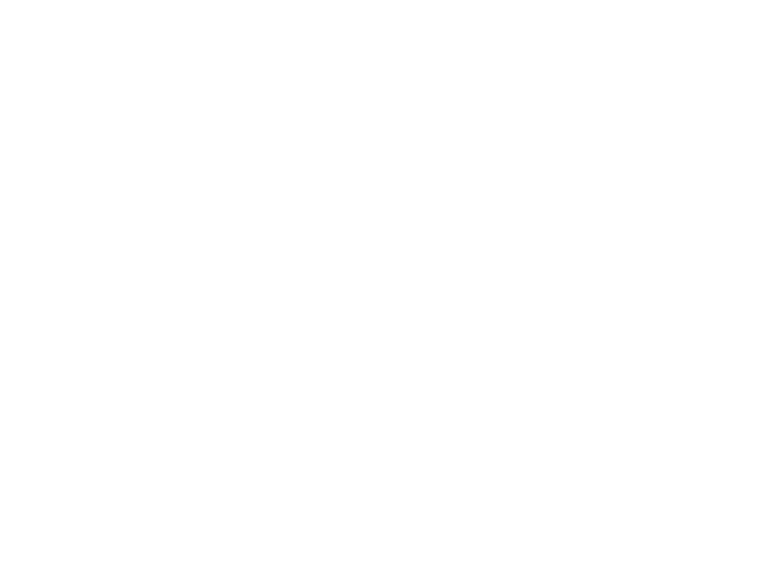

<IPython.core.display.Javascript object>


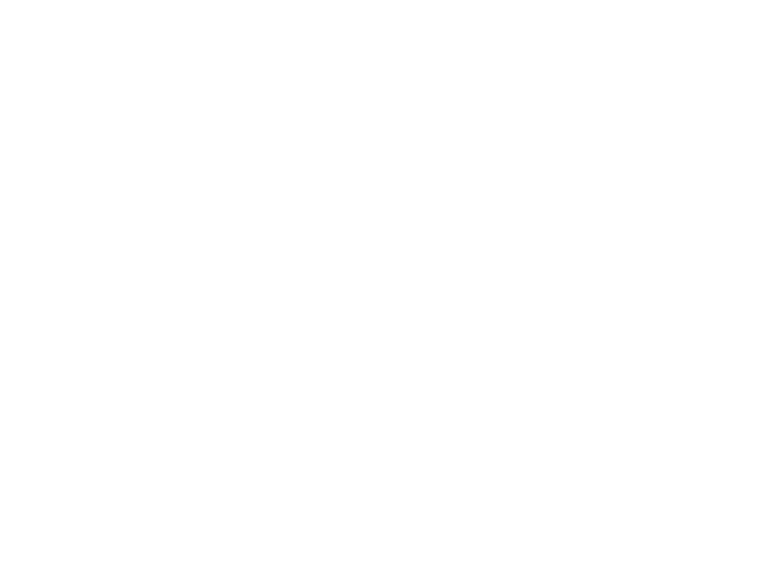

<IPython.core.display.Javascript object>


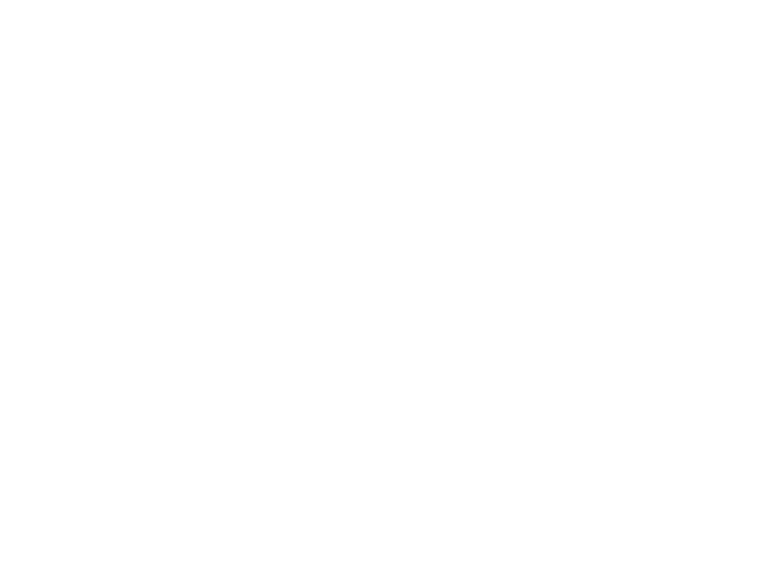

<IPython.core.display.Javascript object>


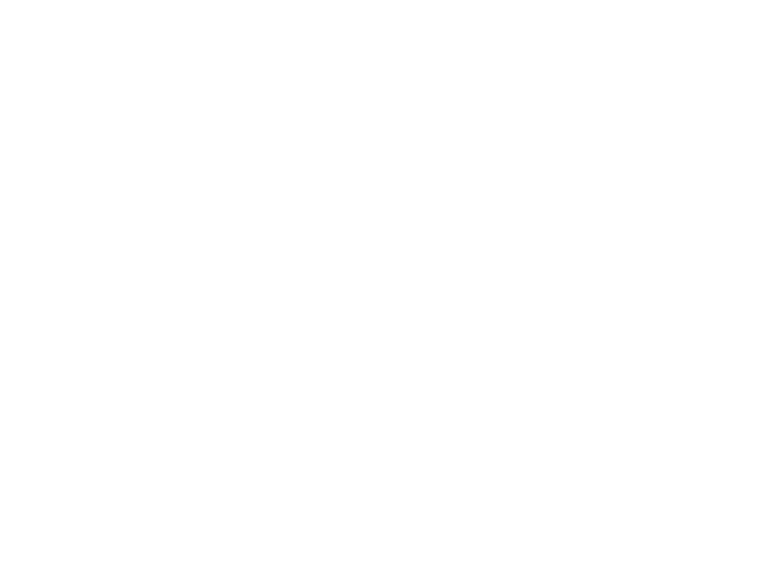

<IPython.core.display.Javascript object>


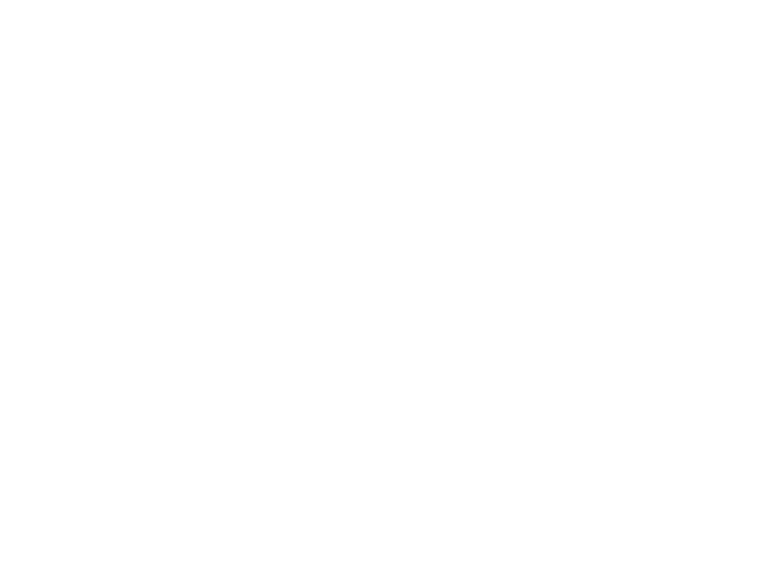

<IPython.core.display.Javascript object>


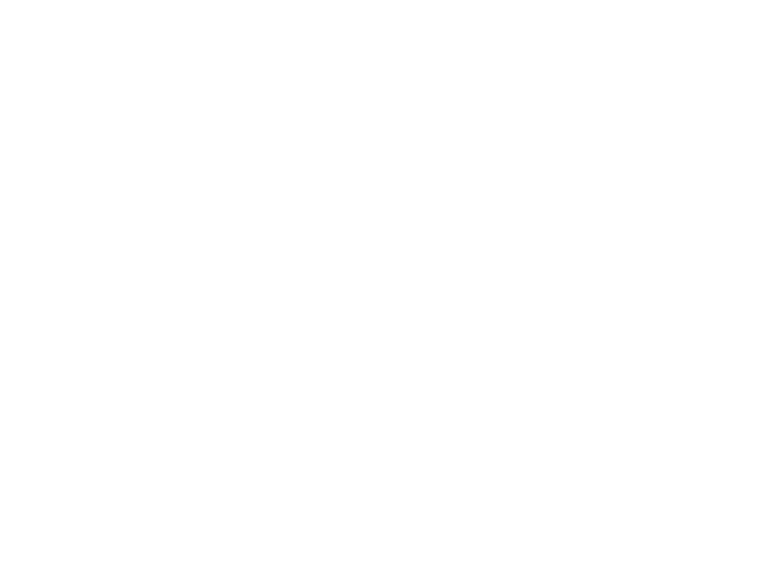

<IPython.core.display.Javascript object>


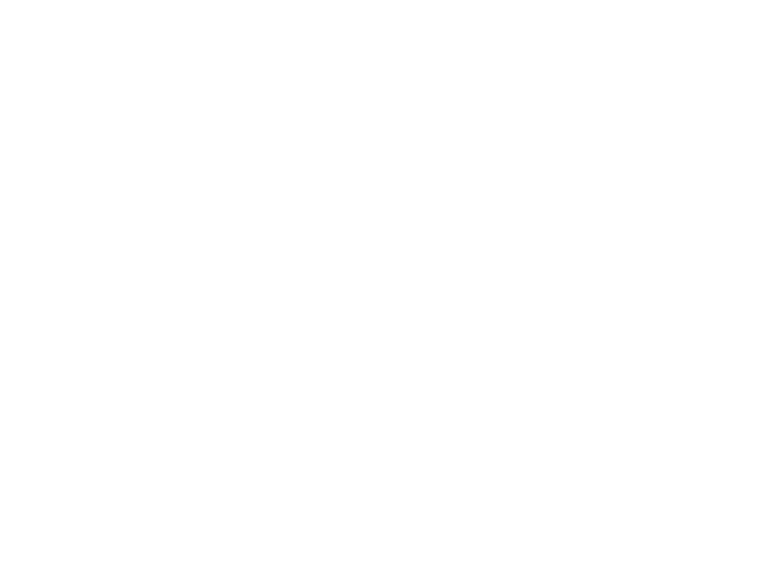

<IPython.core.display.Javascript object>


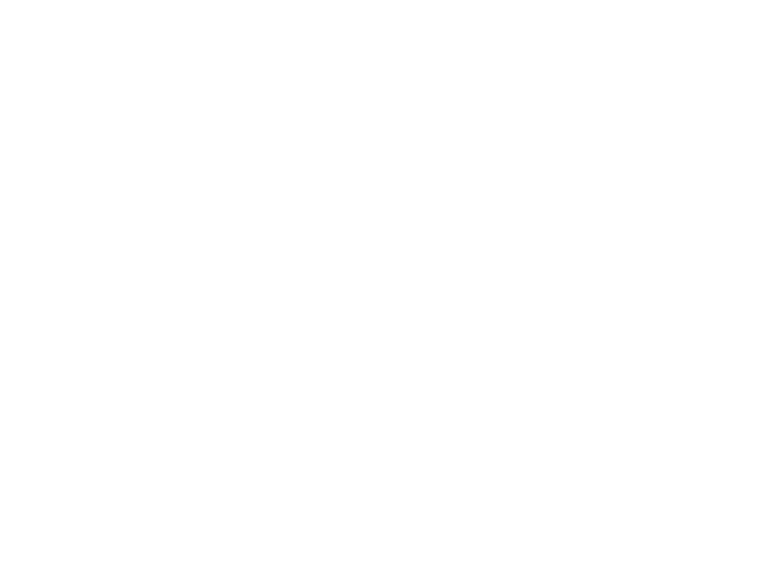

<IPython.core.display.Javascript object>


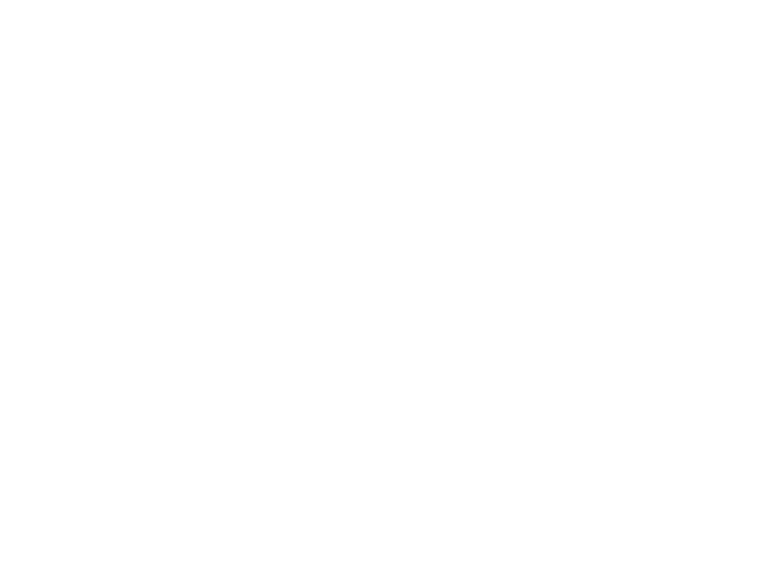

<IPython.core.display.Javascript object>


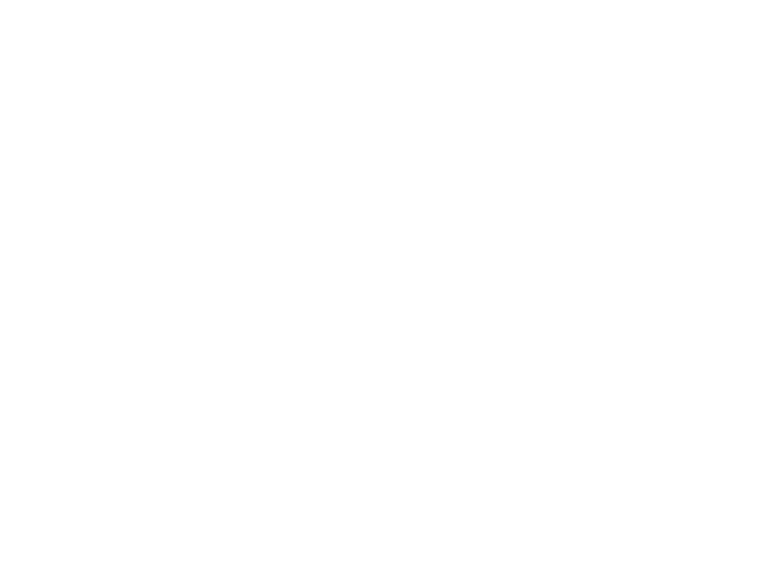

<IPython.core.display.Javascript object>


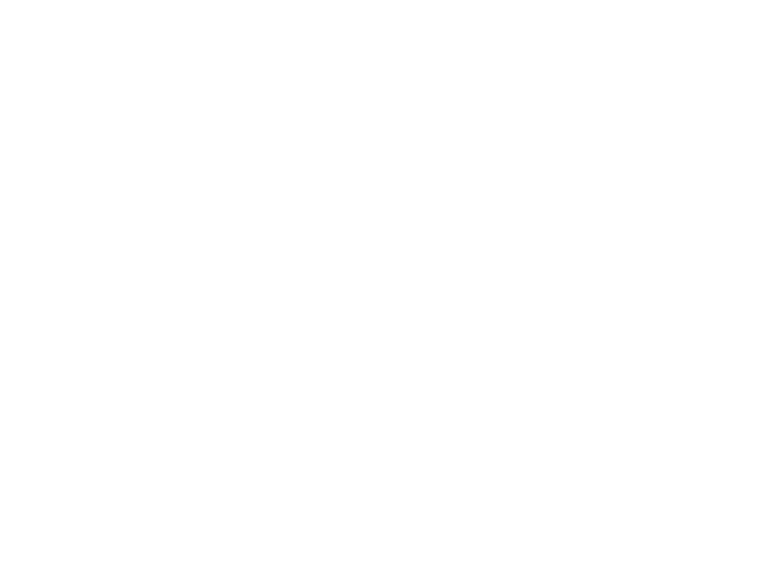

<IPython.core.display.Javascript object>


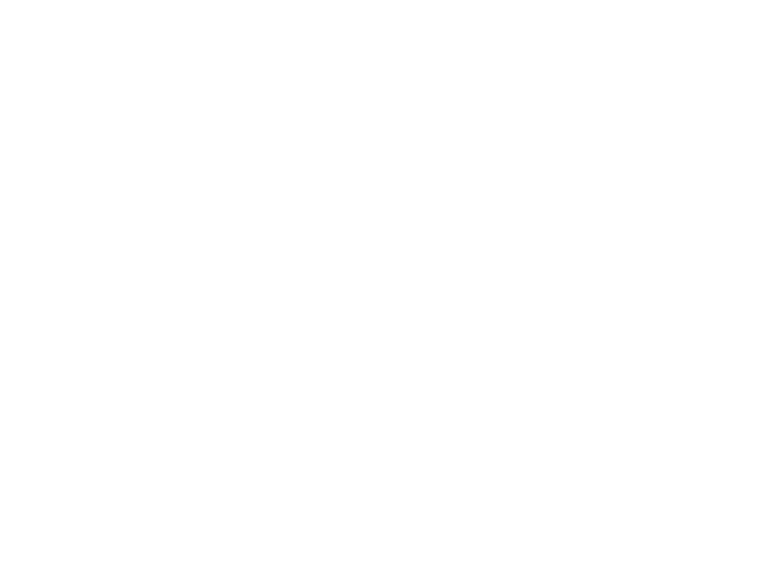

<IPython.core.display.Javascript object>


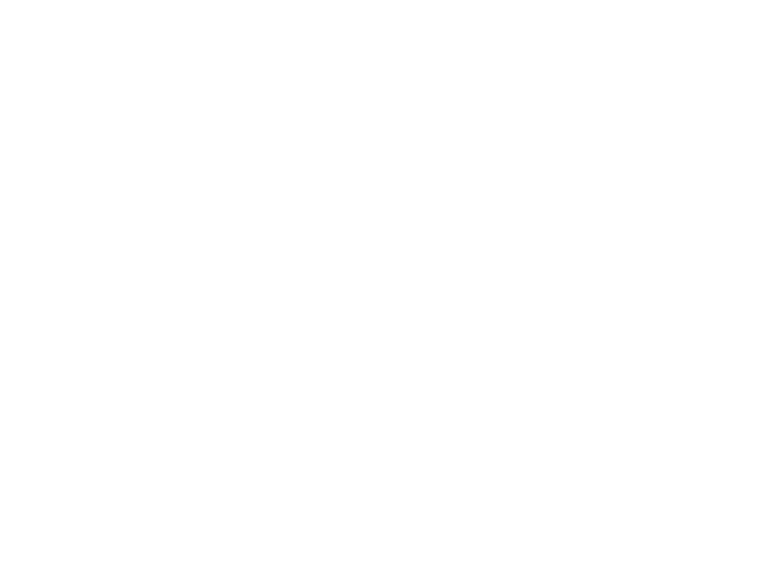

<IPython.core.display.Javascript object>


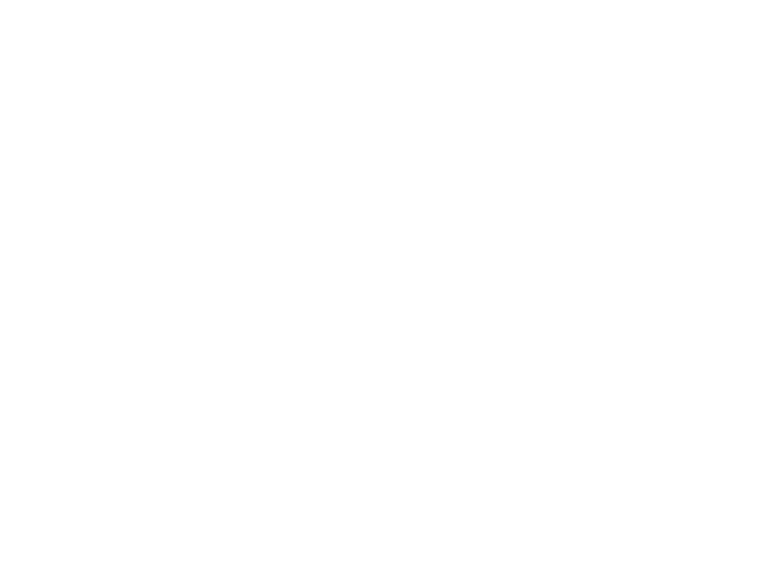

<IPython.core.display.Javascript object>


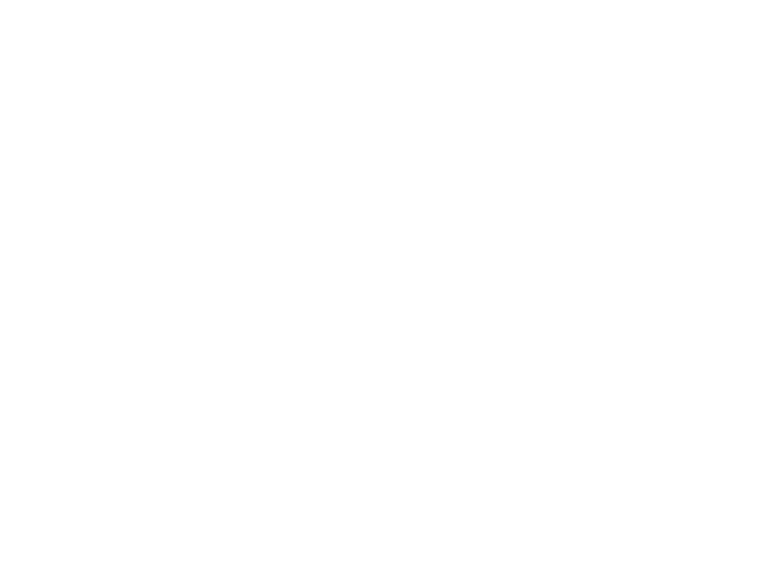

<IPython.core.display.Javascript object>


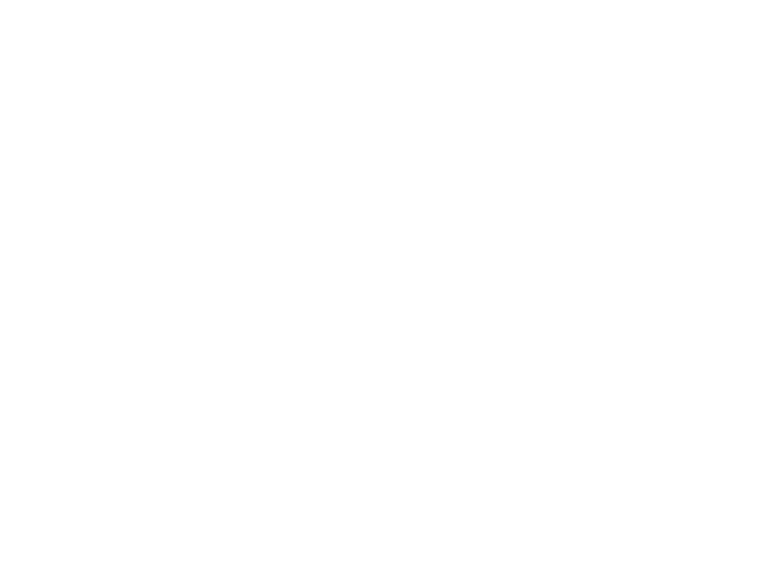

<IPython.core.display.Javascript object>


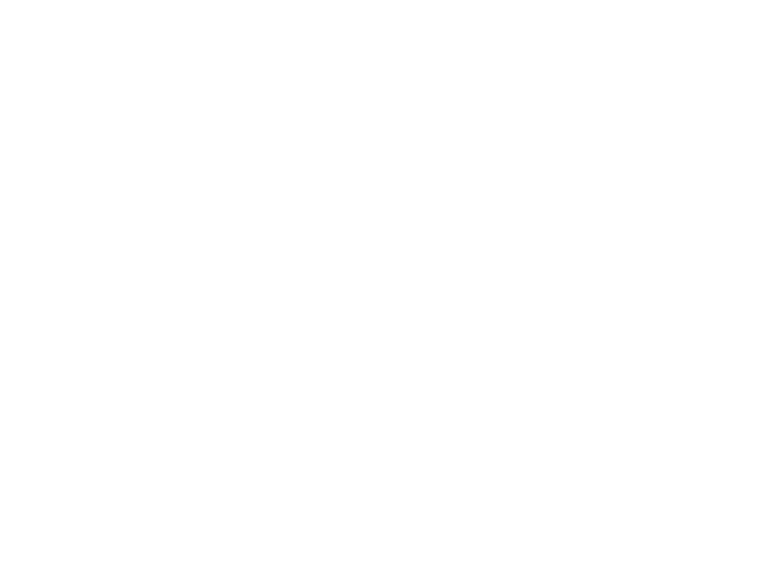

<IPython.core.display.Javascript object>


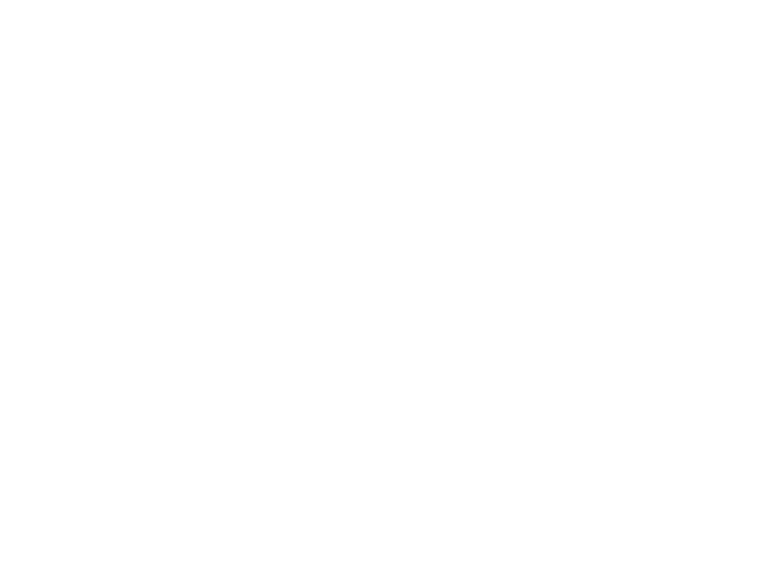

<IPython.core.display.Javascript object>


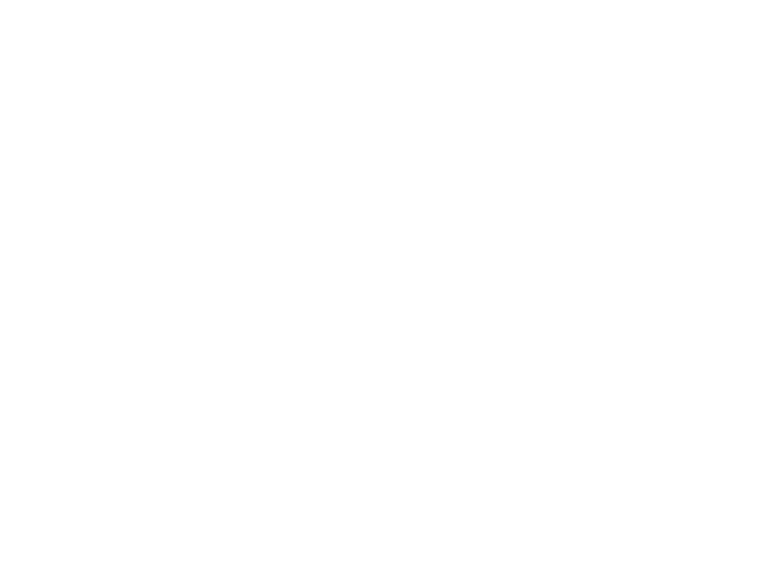

<IPython.core.display.Javascript object>


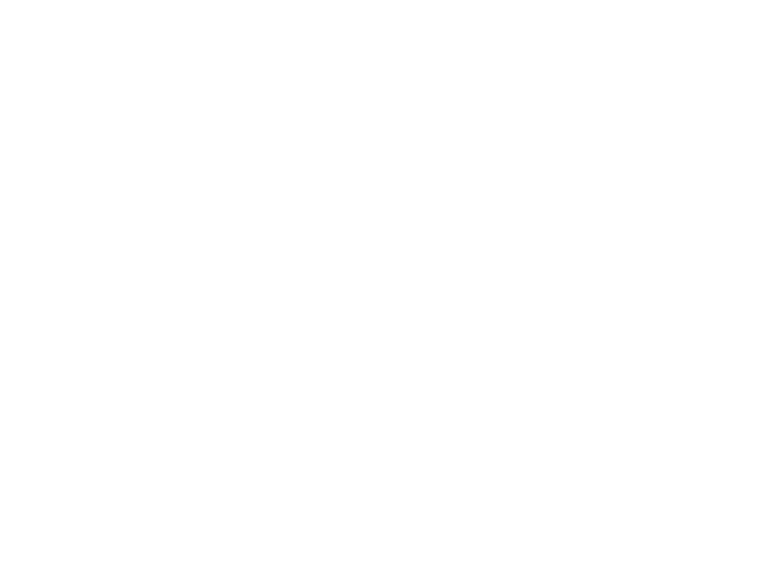

<IPython.core.display.Javascript object>


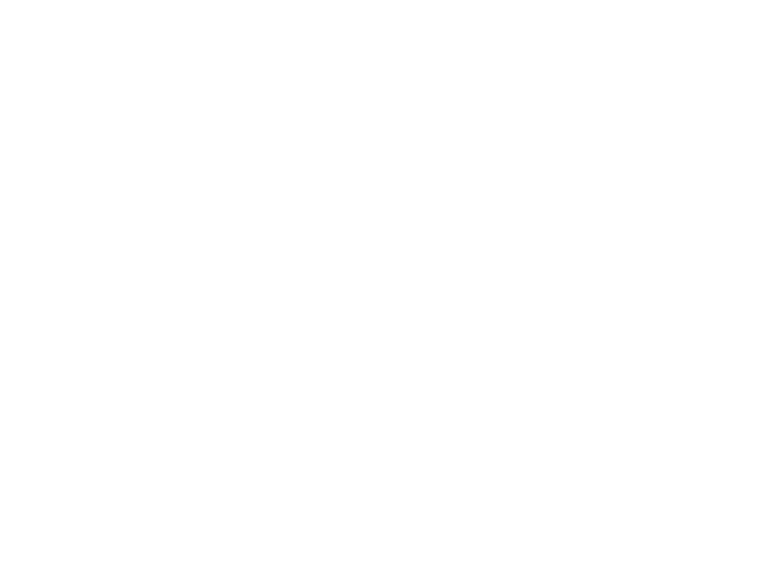

<IPython.core.display.Javascript object>


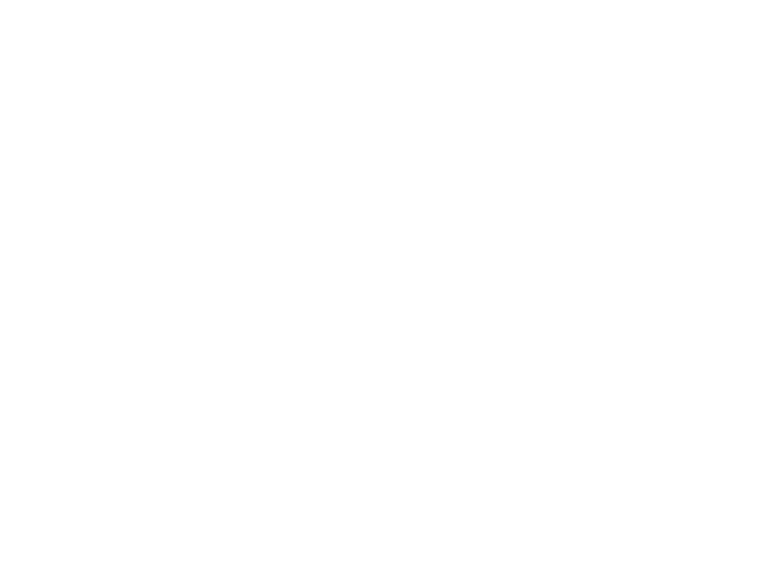

<IPython.core.display.Javascript object>


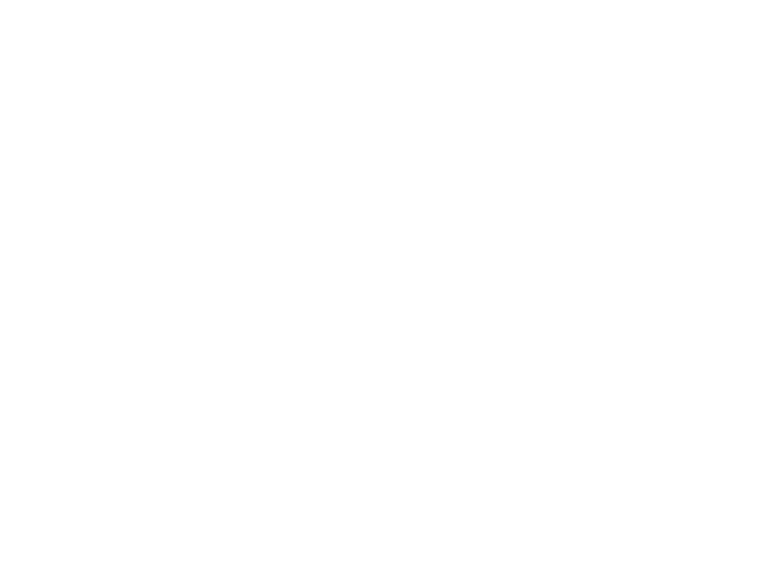

<IPython.core.display.Javascript object>


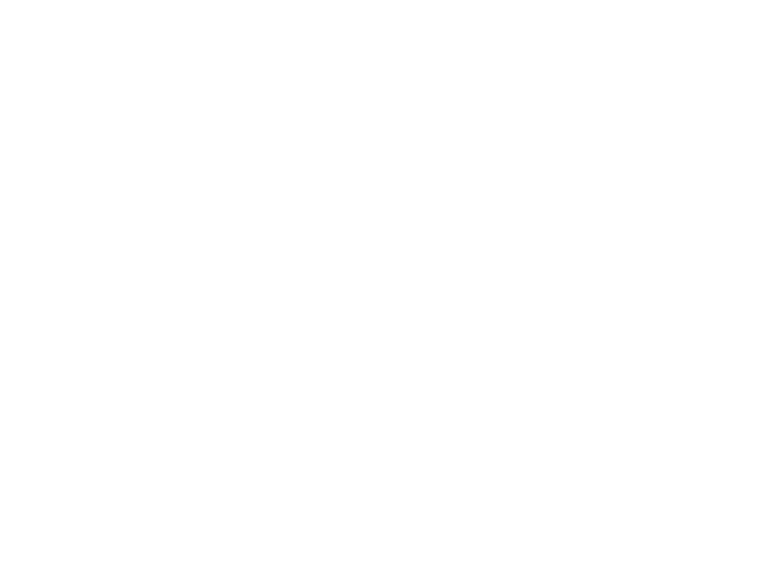

<IPython.core.display.Javascript object>


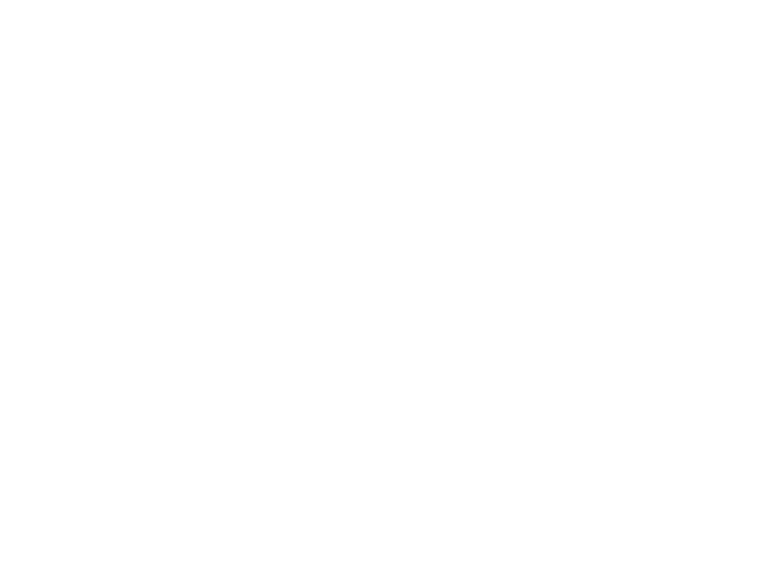

<IPython.core.display.Javascript object>


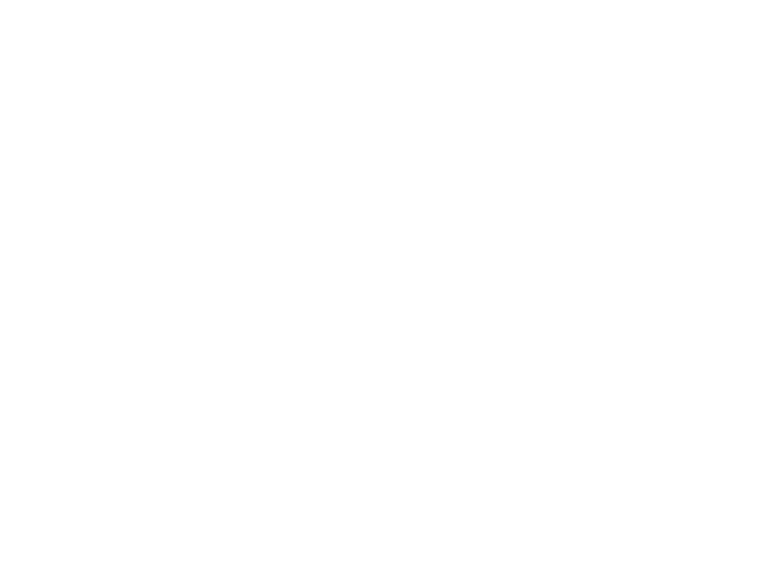

<IPython.core.display.Javascript object>


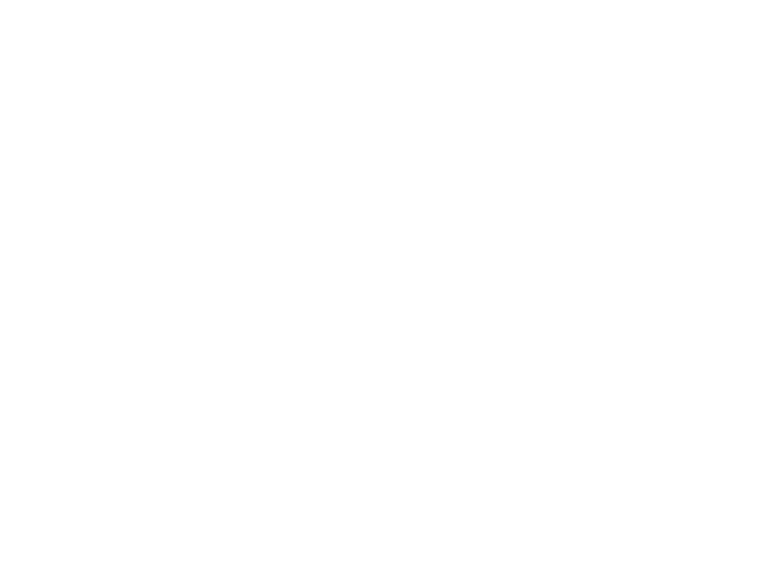

<IPython.core.display.Javascript object>


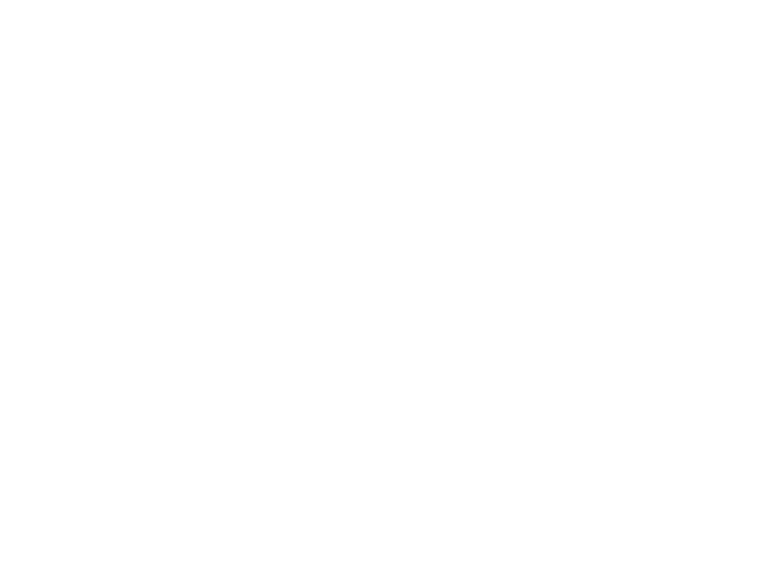

<IPython.core.display.Javascript object>


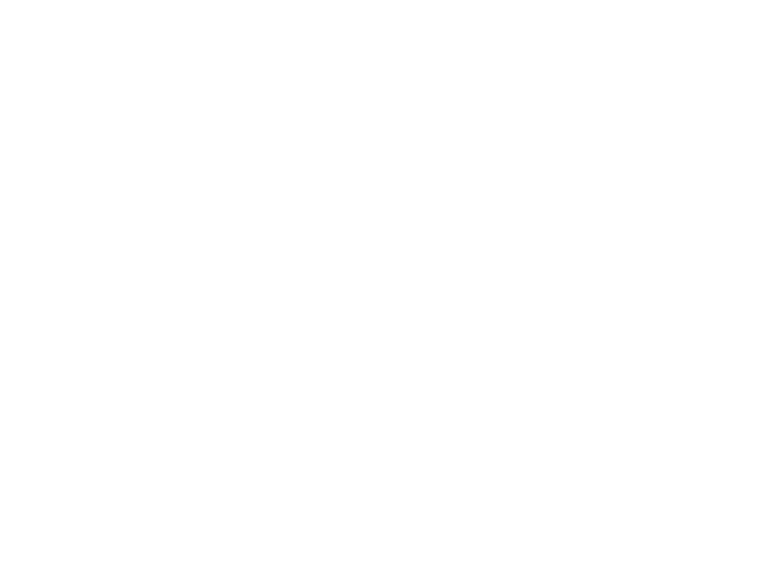

<IPython.core.display.Javascript object>


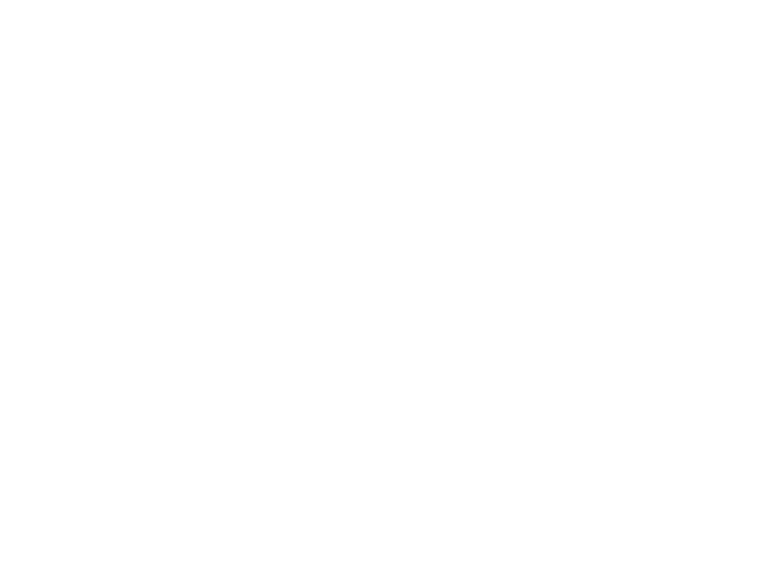

<IPython.core.display.Javascript object>


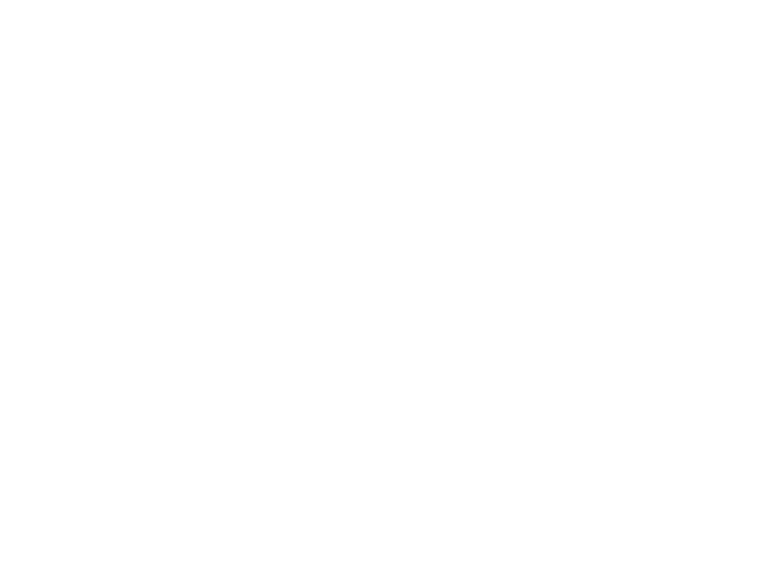

<IPython.core.display.Javascript object>


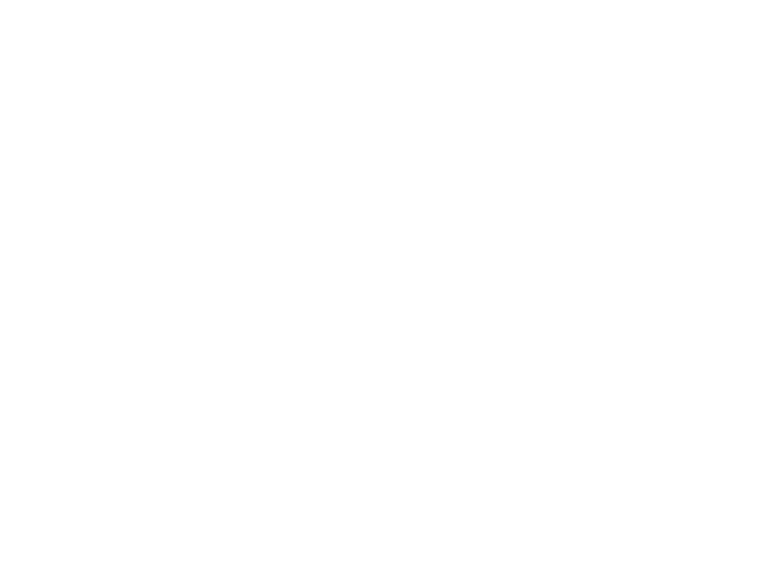

<IPython.core.display.Javascript object>


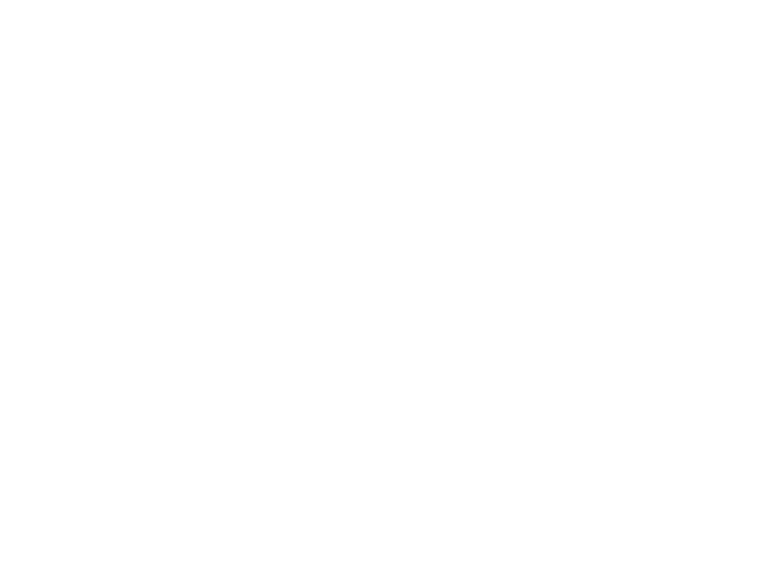

<IPython.core.display.Javascript object>


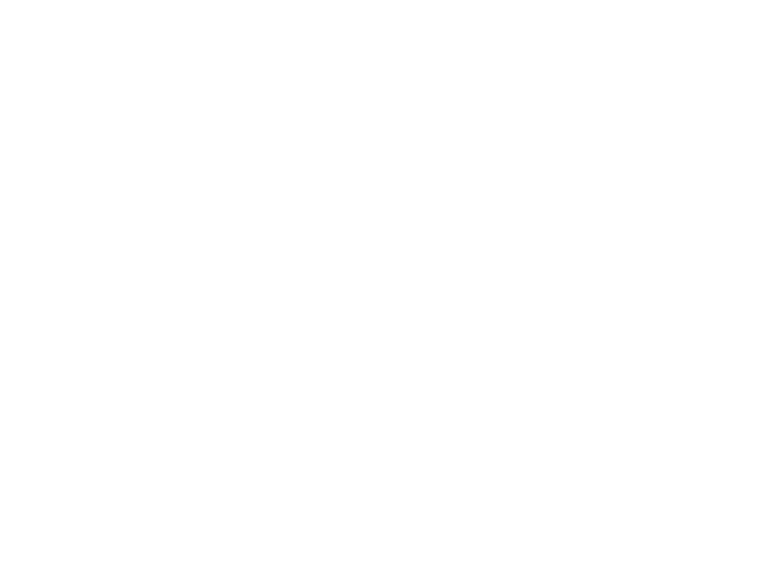

<IPython.core.display.Javascript object>


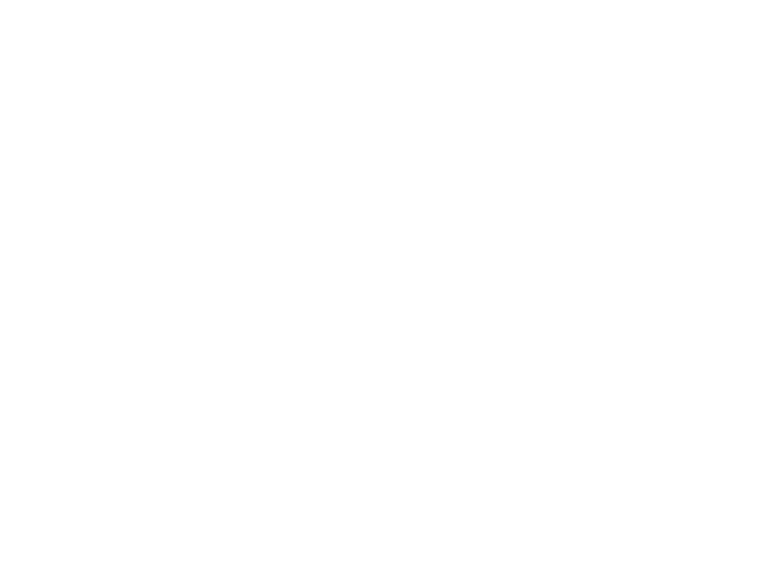

<IPython.core.display.Javascript object>


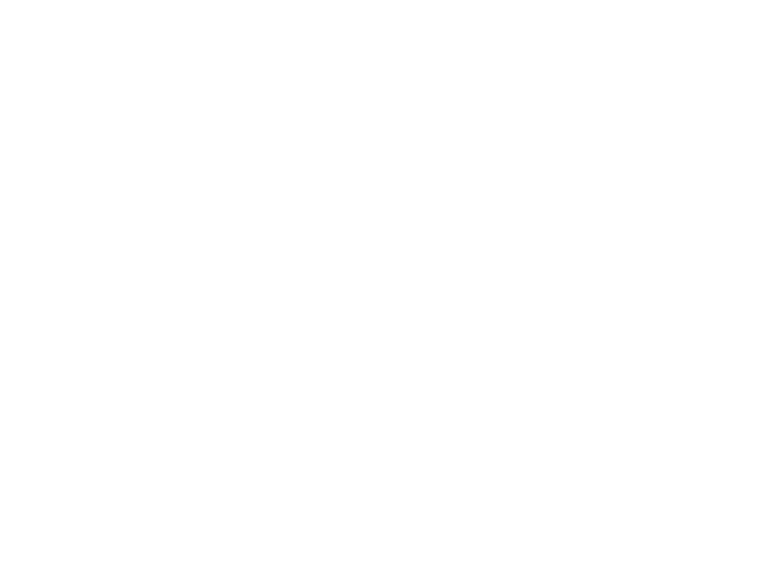

<IPython.core.display.Javascript object>


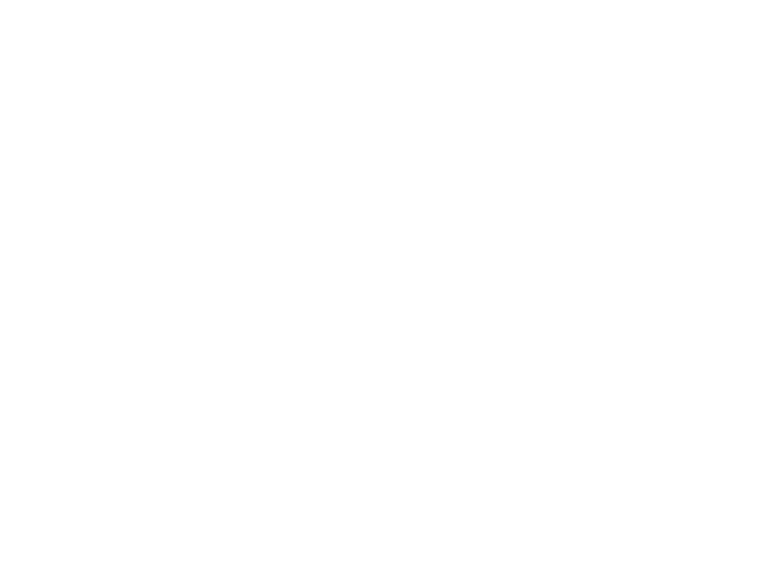

<IPython.core.display.Javascript object>


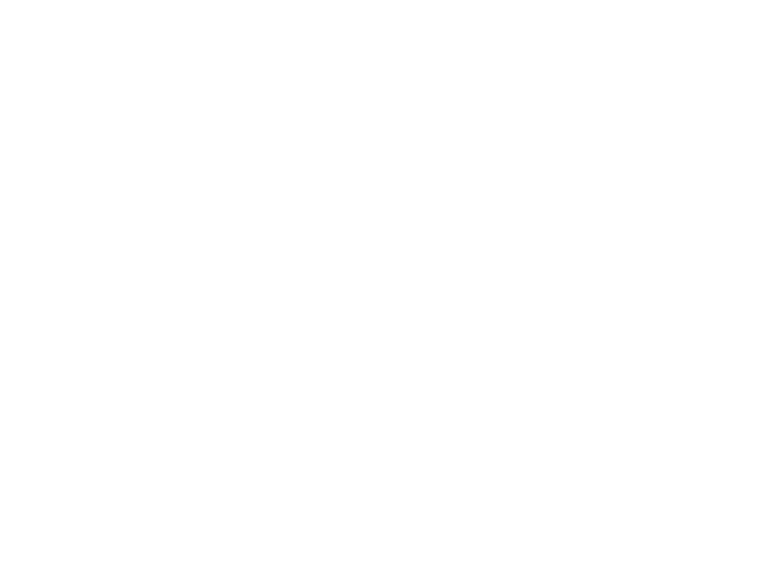

<IPython.core.display.Javascript object>


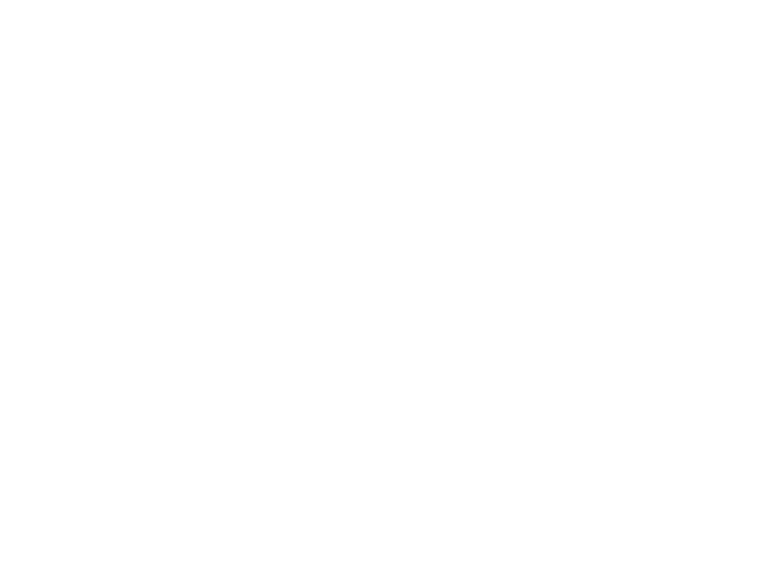

<IPython.core.display.Javascript object>


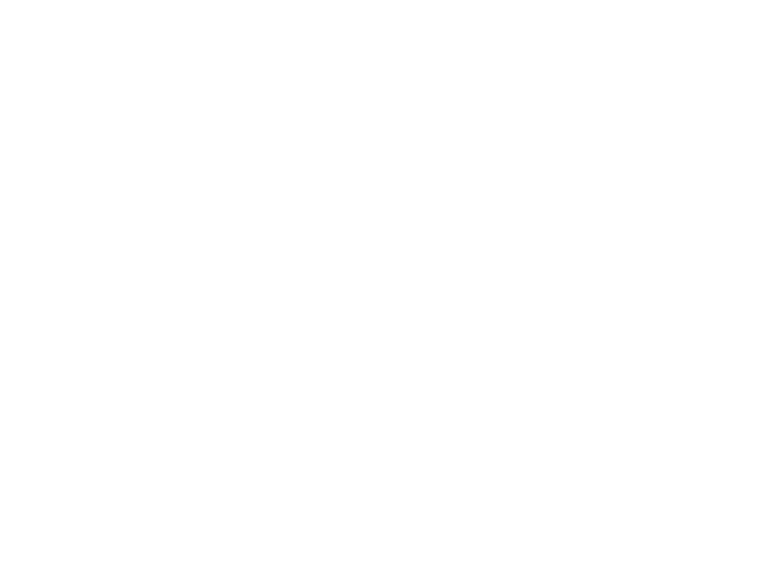

<IPython.core.display.Javascript object>


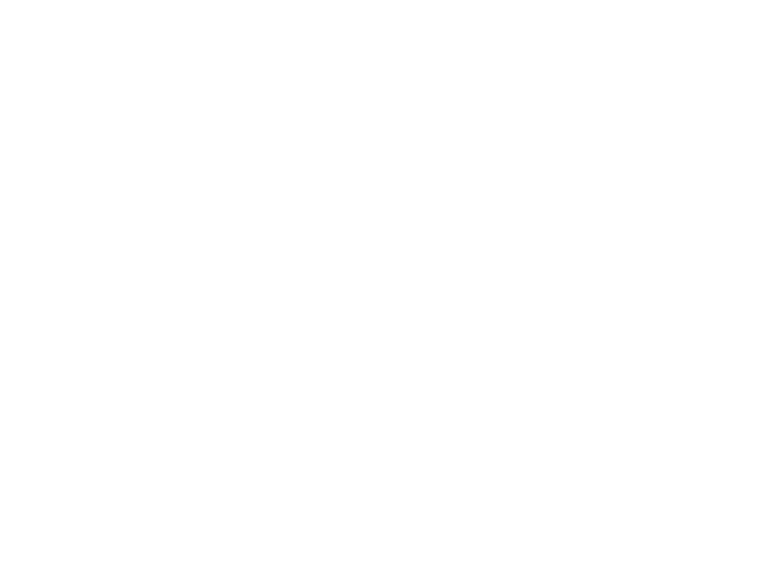

<IPython.core.display.Javascript object>


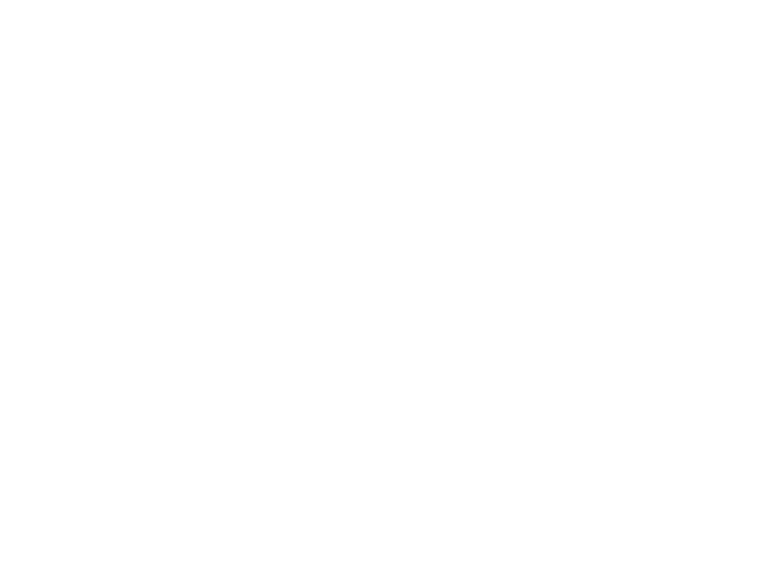

<IPython.core.display.Javascript object>


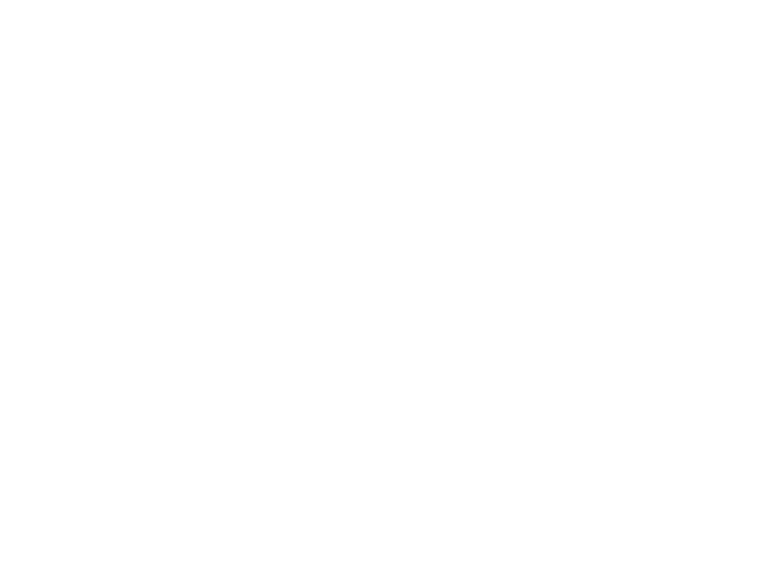

<IPython.core.display.Javascript object>


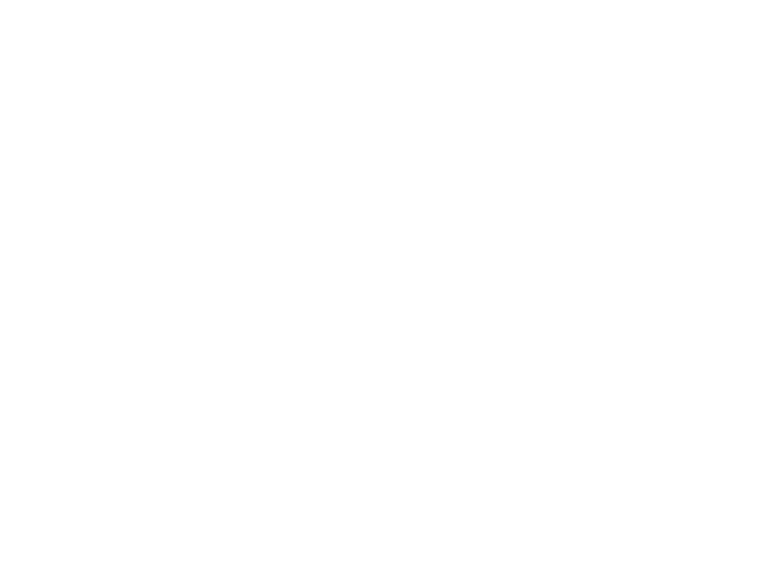

<IPython.core.display.Javascript object>


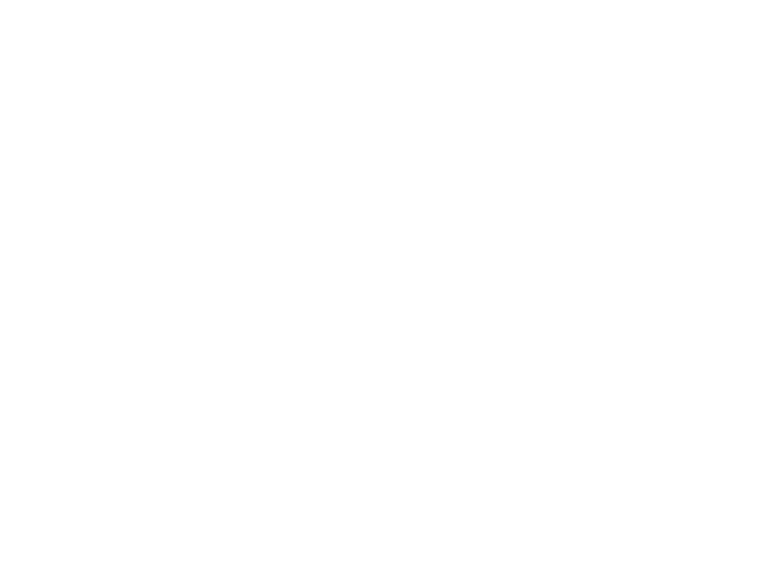

<IPython.core.display.Javascript object>


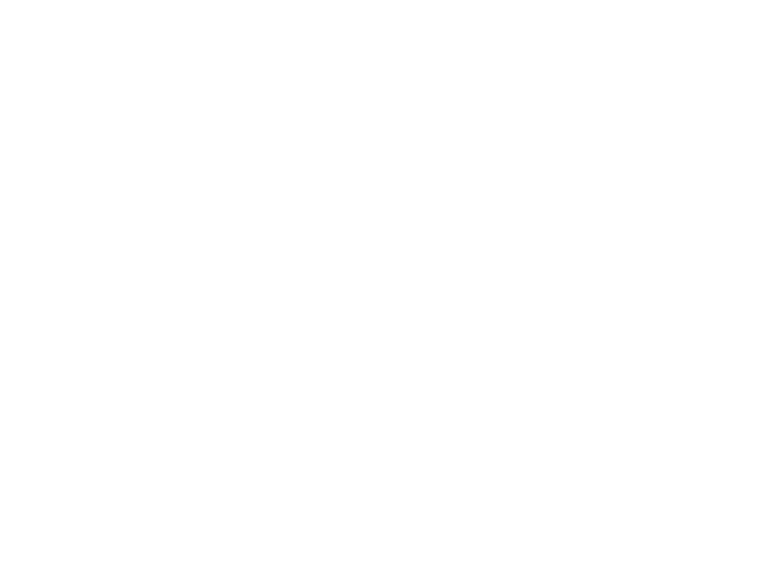

<IPython.core.display.Javascript object>


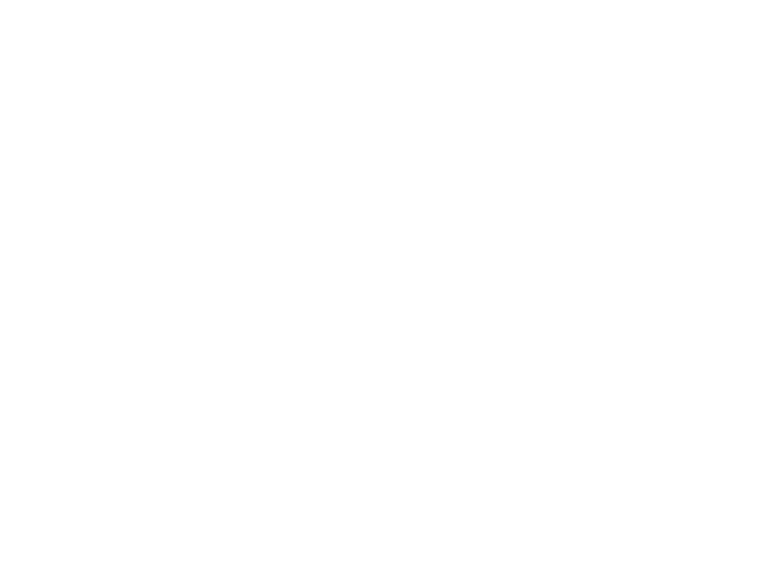

<IPython.core.display.Javascript object>


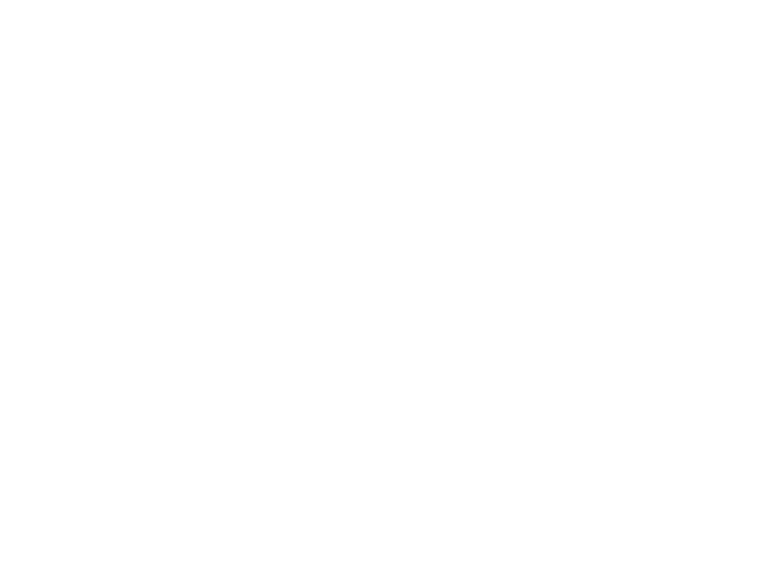

<IPython.core.display.Javascript object>


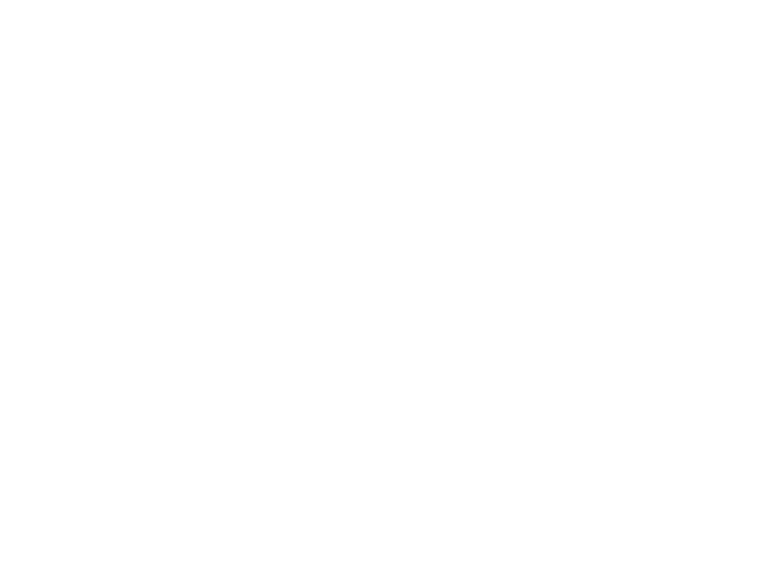

<IPython.core.display.Javascript object>


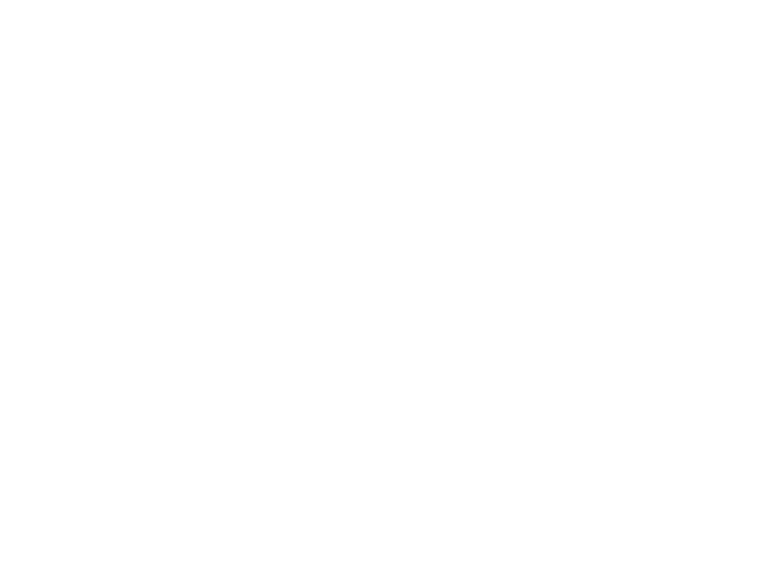

<IPython.core.display.Javascript object>


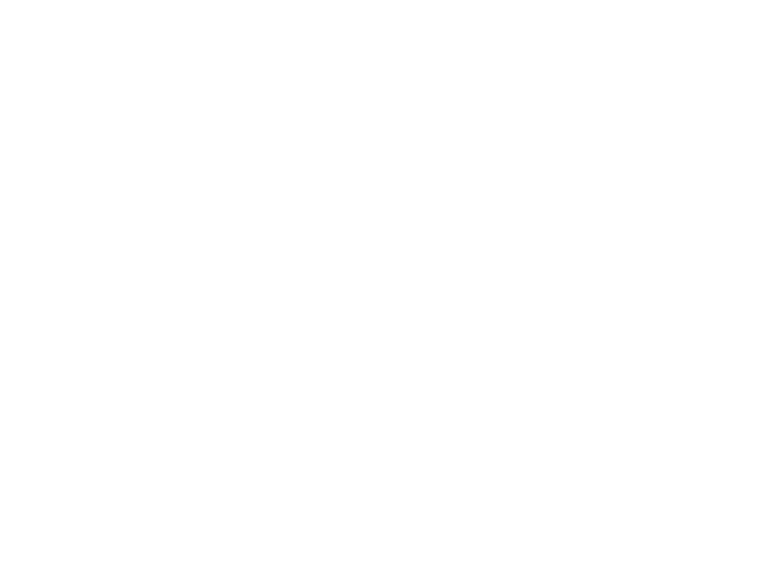

<IPython.core.display.Javascript object>


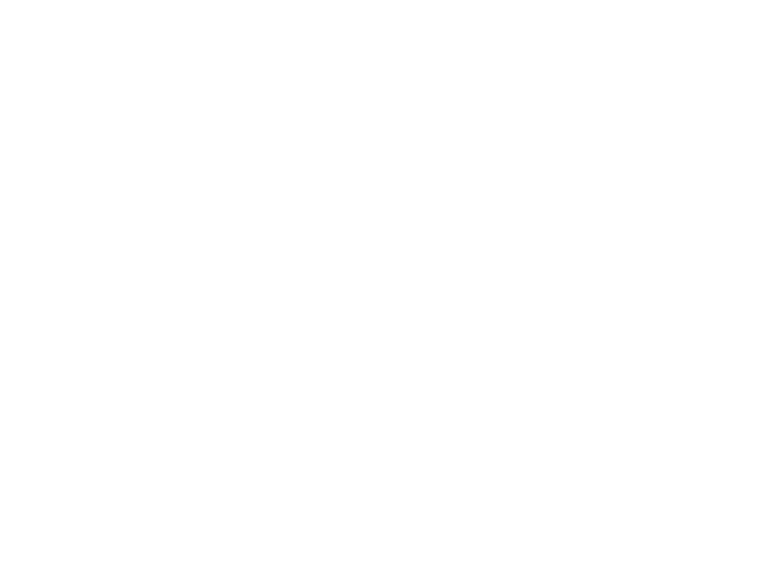

<IPython.core.display.Javascript object>


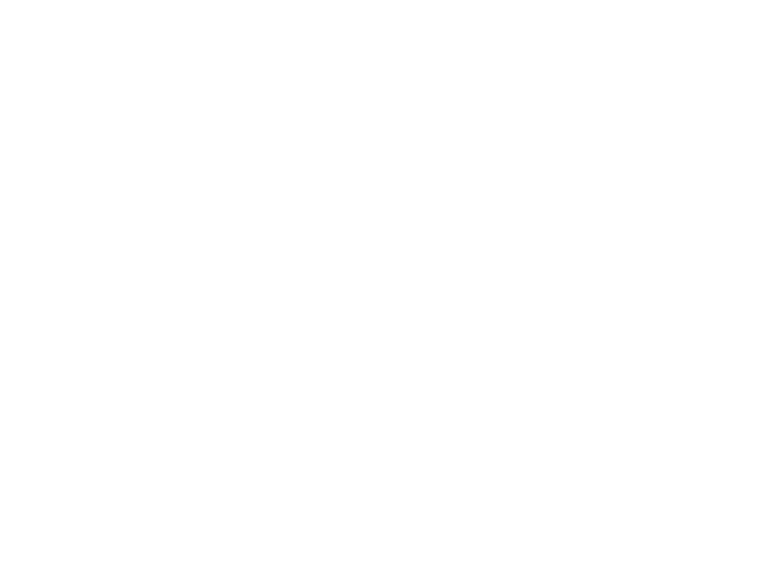

<IPython.core.display.Javascript object>


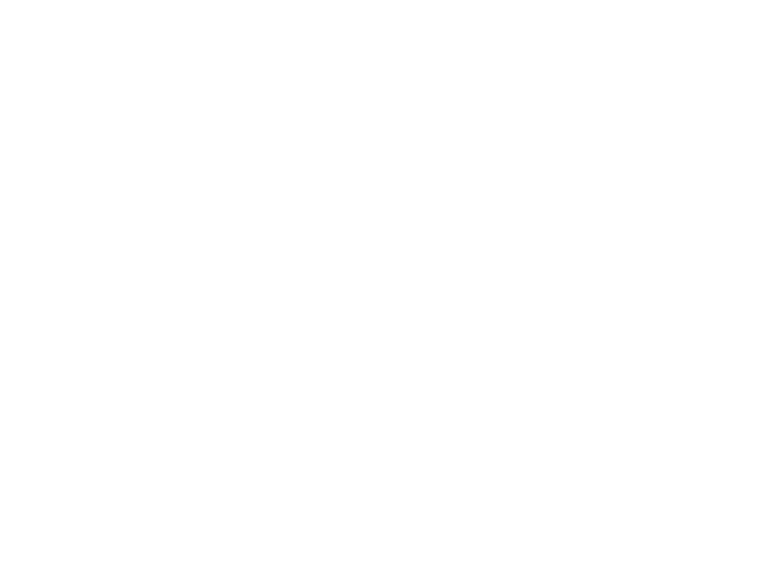

<IPython.core.display.Javascript object>


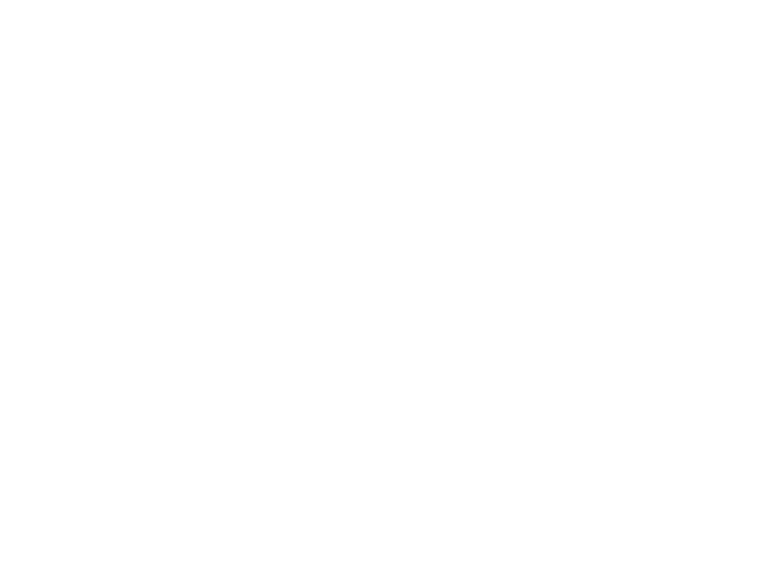

<IPython.core.display.Javascript object>


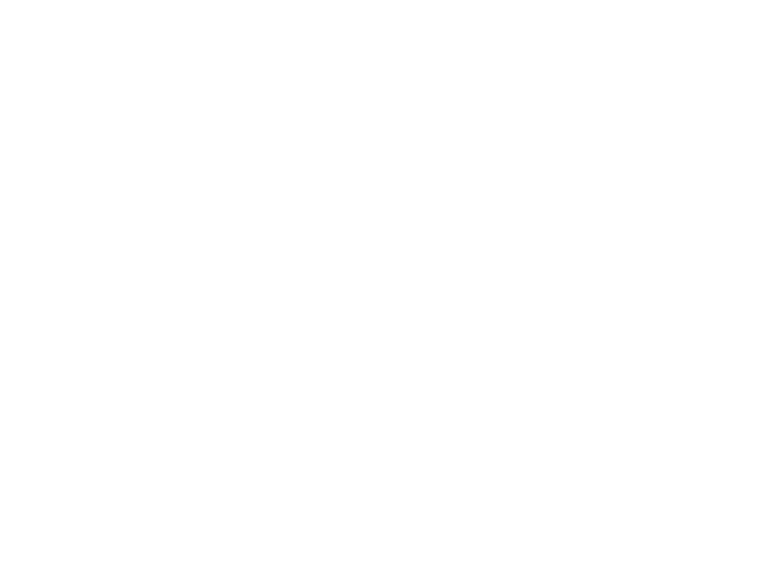

<IPython.core.display.Javascript object>


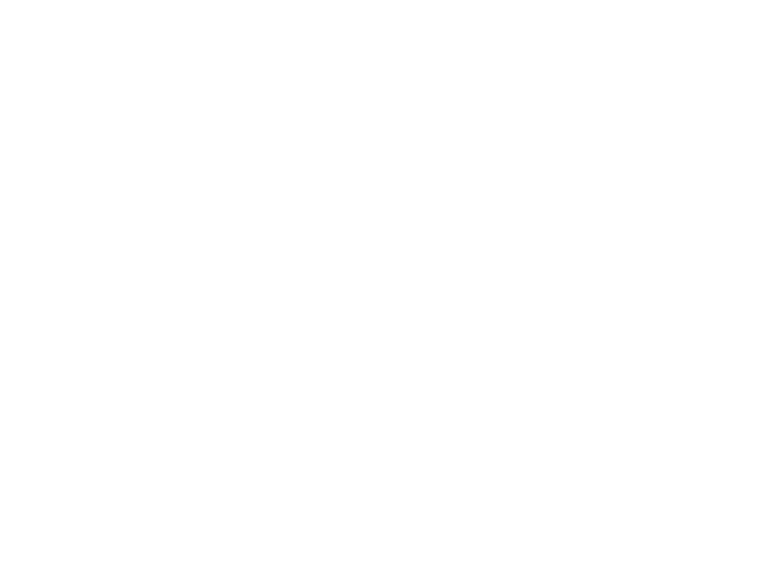

<IPython.core.display.Javascript object>


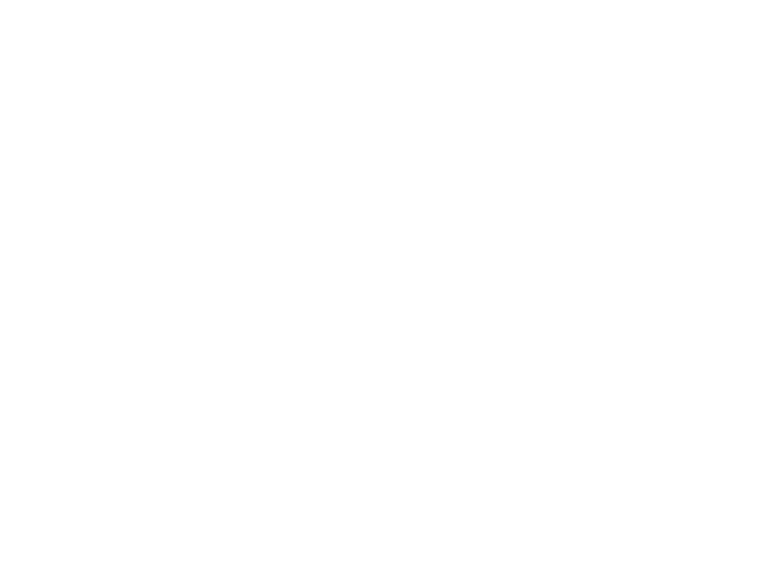

<IPython.core.display.Javascript object>


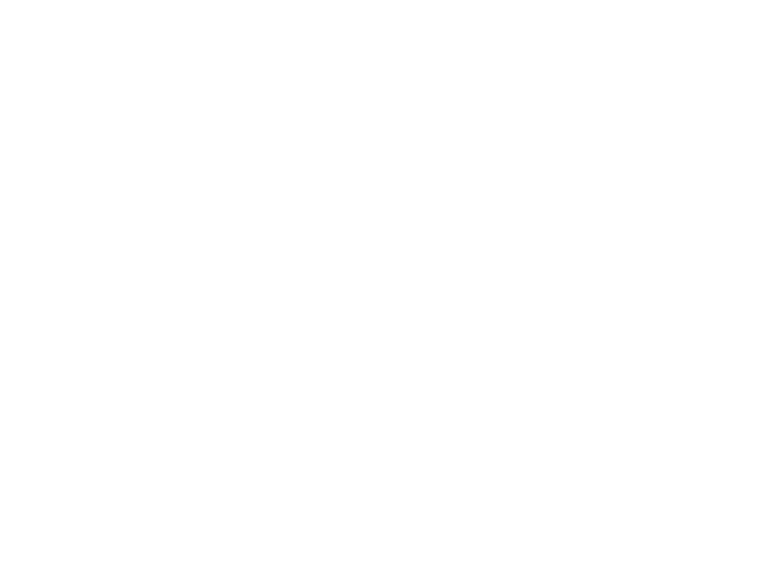

<IPython.core.display.Javascript object>


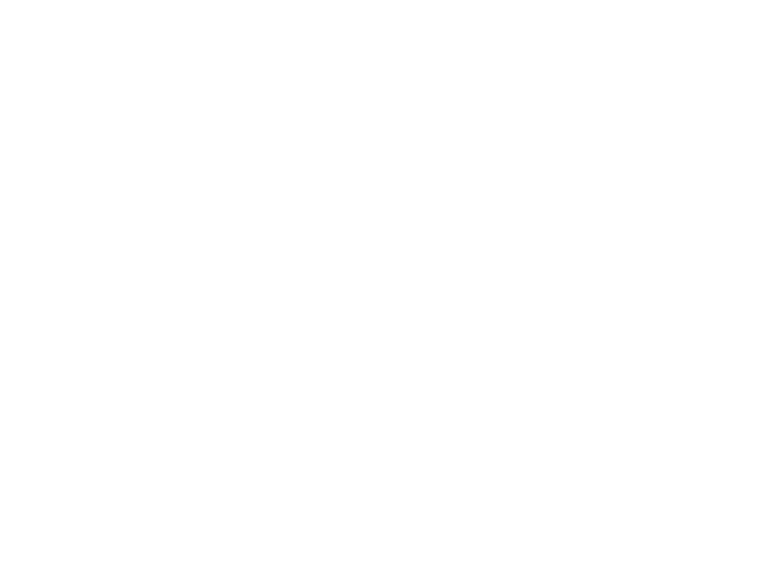

<IPython.core.display.Javascript object>


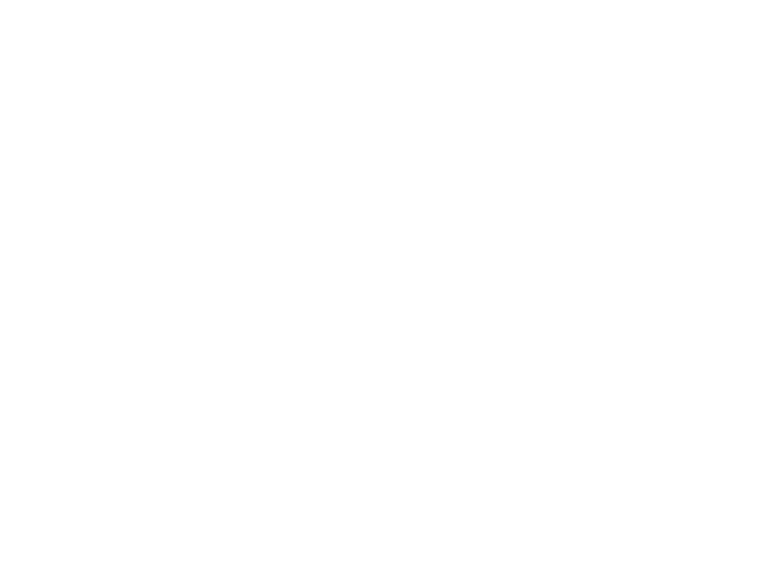

<IPython.core.display.Javascript object>


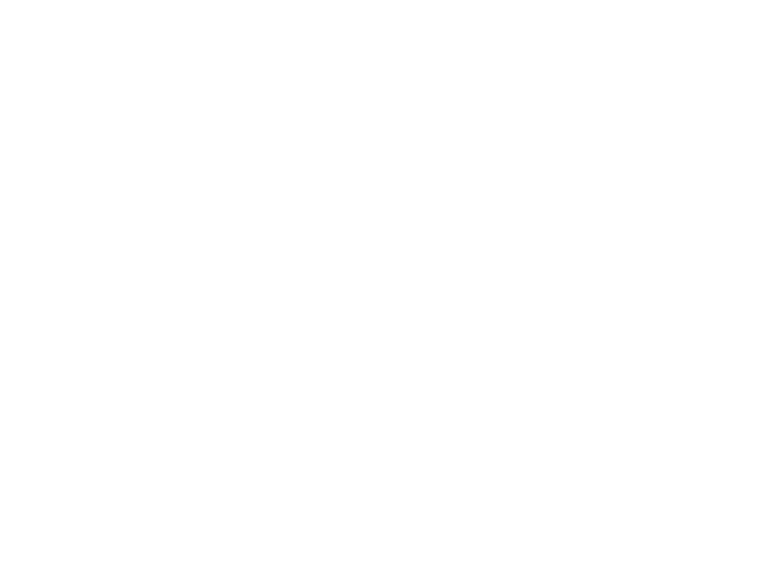

In [43]:
for image_id, n in enumerate(image_names):
    intsy_matrix = single_peak_intensities[n]
    decon_matrix = masserstein_estimation[n]
    for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):  # remove [:4] when finished
        # reformat the data for plotting
        intsy_image = np.zeros(image_shapes[n])
        decon_image = np.zeros(image_shapes[n])
        intsy_segm  = np.zeros(image_shapes[n])
        decon_segm  = np.zeros(image_shapes[n])
        for i, l in enumerate(intensity_coordinates[n]):
            intsy_image[l[0], l[1]] = single_peak_intensities[n][i, lipid_id]
            intsy_segm[l[0], l[1]]  = intensity_segmentation[n][i, lipid_id]
        for i, l in enumerate(masserstein_coordinates[n]):
            decon_image[l[0], l[1]] = masserstein_estimation[n][i, lipid_id]
            decon_segm[l[0], l[1]]  = masserstein_segmentation[n][i, lipid_id]
        plt.figure()
        
        plt.subplot(2, 2, 1)
        plt.title('Peak (profile)\n' + str(round(lipid_sp.confs[0][0], 3)))
        plt.imshow(intsy_image, interpolation='none', cmap=cm.magma)
        plt.axis('off')
        
        plt.subplot(2, 2, 2)
        plt.title('Masserstein\n' + lipid_sp.formula)
        plt.imshow(decon_image, interpolation='none', cmap=cm.magma)
        plt.axis('off')
        
        plt.subplot(2, 2, 3)
        plt.title('K-means')
        plt.imshow(intsy_segm, interpolation='none', cmap=cm.hot)
        plt.axis('off')
        
        plt.subplot(2, 2, 4)
        plt.title('sDGMM')
        plt.imshow(decon_segm, interpolation='none', cmap=cm.hot)
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('Figs/' + n + '_segmentation/%i.png' % lipid_id, dpi=300)
        plt.close()

## Additional analyses 

Inspect the distribution of non-zero signals on a log-scale (just for the sake of curiosity)

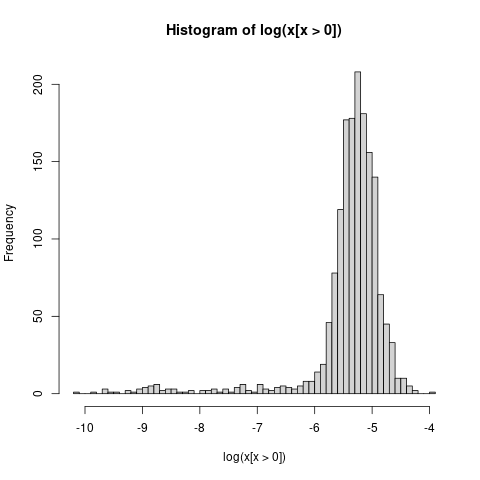

In [44]:
%%R 
hist(log(x[x>0]), breaks=80)


Inspect the distribution of non-zero signals on a log-scale (just for the sake of curiosity)

In addition: Warning message:
In x + 1 + rnorm(nrow(bladder_df), 0, 1e-06) :
  longer object length is not a multiple of shorter object length


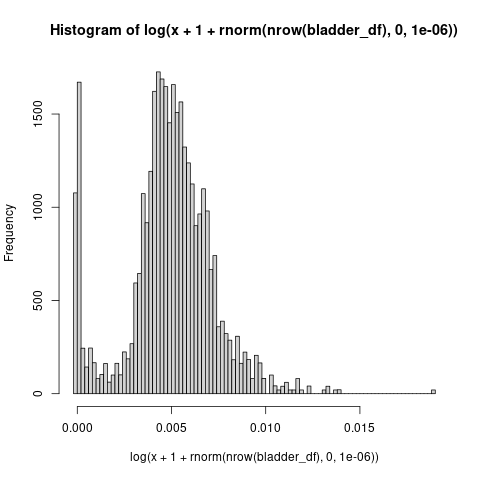

In [45]:
%%R 
hist(log(x + 1 + rnorm(nrow(bladder_df), 0, 0.000001)), breaks=120)